<a href="https://colab.research.google.com/github/qbeslab/LeechNavigationNeuralFields/blob/main/Simulating_Leech_Navigation_Using_Neural_Fields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Dependencies

In [ ]:
from numpy.lib import scimath as sm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from math import sin, cos, radians, pi
from sklearn.preprocessing import normalize
import time
from scipy.integrate import odeint
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML, display
from google.colab import files
from scipy.optimize import fsolve
import random
import pandas as pd
from tabulate import tabulate
import matplotlib as mpl
from tqdm.notebook import trange, tqdm
import seaborn as sns
from pathlib import Path
from datetime import datetime
from glob import glob
import ipywidgets as widgets
import re
# First mount google drive to this file
from google.colab import drive
drive.mount("/drive", force_remount=True)

Mounted at /drive


In [ ]:
# customize this path to a working directory on Google Drive where Colab can
# write simulation results
working_dir = Path('/drive/My Drive/Taylor Lab/Leech Navigation Neural Fields/')

# create the working directory and all parent directories, if they do not
# already exist
working_dir.mkdir(parents=True, exist_ok=True)

# 1. Introduction


The purpose of this code is to create a simulation that mimics the sensing, planning, and acting of a medicinal leech. The simulation is supposed to replicate actual leech navigation behavior and reproduce find rate data from previous animal studies. We developed an agent based simulation where the agent represents a leech moving around in an environment. The environment contains water wave ripples of which the leech-agent senses with sensors distributed around its body. The information from the sensors are processed via a dynamic neural field. The output from the neural field guides the motion and turn rate of the agent, with the hopes of directed it towards the water wave origin.

We split the simulation up into 4 components. The Environment, which defines the boundaries for the leech-agent, as well as the stimulus origin and the area around the stimulus origin the leech-agent must try to stay in. Then the AgentNF, NF standing for neural field since this is the sensory processing unit connected to the agent. Then WilsonNF, which comprises of a neural field model adapted from Hugh Wilson's winner-take-all model from his Spikes, Decisions, and Actions Book. And finally the Wave object which is used to control the motion 2D water waves.

These four components are combined and initialized in a Simulation object. This object contains an update function that updates the Agent's sensors, the neural field processing, and the agent's position and orientation. The update function loops over a specified number of timesteps until the agent reaches the target location or runs out of time. The Simulation object outputs a set of positions the agent traveled, creating a trajectory plot, as well as a binary find rate flag (successfully found target, failed to find target).

This notebook is meant to provide a demo and tutortial on how to use the simulation code. This will allow researchers to create their own agent-based simulations to study the affects of leech (and other animals) navigational beahvior due to different sensory inputs, sensory processing techniques, agent stucture compositions, ect.

## 1.1 Notebook Usage Tips

- The user can locate "Runtime" in the upper left corner and select "Run All" to quickly run all of the cells within the notebook.

- Locate the Table of Contents on the far left hand side by clicking the icon with the three horizontal line, Screen Shot 2021-06-09 at 3.03.33 AM.png. This gives clickable links to each section making it easier to navigate through the notebook.

- When trying to code with multiple code cells within the notebook, click the icon Screen Shot 2021-06-09 at 3.00.57 AM.png, located at in the upper right hand corner in the code cell, to split the screen, showing both cells side by side.

- Click the small arrows to the left of each section to compress it, making it easier to scroll through the notebook.


# 2. Behavioral Environment

## 2.1 Initialization

Here we have the Environment object. It is initialized with a radius, an x,y coordinate to control its center position, and an angle to control the position of the target location. For now only create square environment instances. The target location angle is inputted in degrees and corresponds to a location along the edge of a circle within the boundary around. For example, 0 degrees corresponds to the right-most position, 90 degrees corresponds to the top-most position.

## 2.2 Environment Source Code

In [ ]:
### Leech navigational environment

class Environment():
    def __init__(self,r,x,y,targetLoc):

        self.r = r #Define radius of environment
        self.x = x #Define x,y coordinates for center
        self.y = y
        self.area = 2*pi*(r**2)
        targetLoc = targetLoc*(pi/180)
        ### Define target location
        rG = 7
        self.rG = rG #target radius
        self.aG = targetLoc #target position in environment
        self.xG = (r-self.rG)*cos(targetLoc)+r
        self.yG = (r-self.rG)*sin(targetLoc)+r

    def setTargetLocation(self,x,y):

        if x > self.x+self.r or x < self.x-self.r:
          return "x out of bounds"
        if y > self.y+self.r or y < self.y-self.r:
          return "y out of bounds"
        self.xG = x
        self.yG = y
        return self.xG, self.yG


    def plotEnv(self):

        boundary = plt.Circle((self.x,self.y),self.r,color='black',fill=False)
        target = plt.Circle((self.xG,self.yG),self.rG,color='black',fill=False)
        fig, ax = plt.subplots()
        ax.add_artist(boundary)
        ax.add_artist(target)
        ax.set_xlim((0, self.x*2))
        ax.set_ylim((0, self.y*2))
        ax.set_aspect('equal')

## 2.3 Example Environment

In this example we initialize an environment with a radius of 50, and a center point at (50,50). We place the target location at an angular displacement of 90 degrees along the edge of the boundary (measured counterclockwise from the right/east).

**Environment.plotEnv()** outputs a boundary circle and the target location area. Note that in the actual simulation the agent is confined to the square surrounding the plot and not the circle. This simplifies boundary collisions.

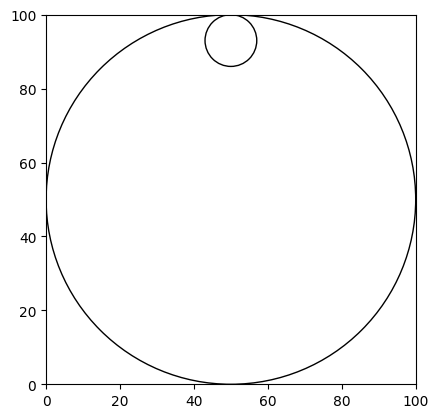

In [ ]:
testEnvironment = Environment(50, 50, 50, 90)
testEnvironment.plotEnv()

Manually set target location with **Environment.setTargetLocation(x, y)** if a more precise location is required.

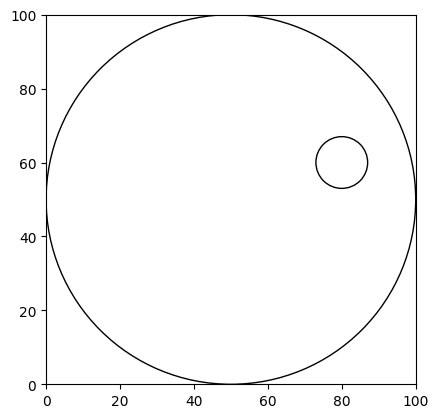

In [ ]:
testEnvironment.setTargetLocation(80, 60)
testEnvironment.plotEnv()

# 3. Neural Field

## 3.1 Initialization and Setter Functions

We now create the WilsonNF object. Wilson is from the creator, Hugh Wilson, and nf stands for neural field. We initialize this object before the AgentNF because the AgentNF requires a WilsonNF instance in its constructor. The WilsonNF is initialized with a time constant, *tau*, which is responsible for controlling how quickly the neural field updates.

The field is initialized with 24 nodes as a default (*self.n*). The number of nodes can be manually set with the **WilsonNF.setNumOfNodes(*n*)** function. *self.n_spaces* refers to the angular interval size, therefore if there are 24 nodes, then n_spaces is 15$^\circ$ since each node is seperated by 15$^\circ$ increments. There is optional code within this function that scales the weighting array according to the number of nodes set. It only has code for 8, 24, and 72 nodes for now. *self.encodedAngles* refers to the encoded directions for each node spanning from -180$^\circ$ to 180$^\circ$ (angles are measured counterclockwise from the agent's head/orientation vector). The angles are stored in radians.

The neural threshold (*self.threshold*) is set at 2.5 but can be set manually using the **WilsonNF.setThreshold(*thresh*)** function. This variable controls the neural activation threshold. When a node surpasses this threshold during activation, its encoded direction is added to a *percievedDirections* list. The agent randomly chooses an angle from this list to control its turn rate.

The neural decay (*self.decay*) is set to 0 but can be set manually using the **WilsonNF.setDecay(*d*)** function. This variable controls the rate at which the neural field decays over time. In certain situations the neural field may recieve a zero input to all of its nodes (this occurs when the sensors are deactivated) and therefore decays at a constant rate.

The angular noise (*self.angNoise*) is set to 90$^\circ$. It can each be manually set using **WilsonNF.setAngNoise(*angNoise*)**. *self.angNoise* controls the variance of a zero mean univariate normal (Gaussian) distribution. A more detailed description on adding noise is provided later in this section.

The weighting array (*self.weight*) is manually constructed to work for a neural field with 24 nodes. Reference the **WilsonNF.setNumOfNodes(*n*)** function for sample code on how to adapt this array for different numbers of nodes.

*self.tau* is the time constant which controls the rate at which the neural field is updated. *self.maxTime* is set to 6000 seconds since this was the maxTime used in our simulations. *self.numFrames* calculates the total number of timesteps (also frames) the neural field may undergo. This variable is used to allocate space for lists and matrices to store data from the neural field.

The rest of the variables within the neural field are lists and matrices used to store input and output data for the neural field.

*self.sensorSwitchFrames* is an extra variable used in the surface plots to label at what time the sensors are activated/deactivated.

## 3.2 Helper Functions and Main Update Functions


 - **WilsonNF.resetVals()** resets all of the ouput storage variables. This is
useful for running multiple simulations and should be called anytime a new simulation is performed. It is automatically called when the simulation is reset.

- **WilsonNF.polVect_to_compVect(*v*)** is a helper function used to convert polar vectors to component vectors. *v* is an nx2 matrix where there are *n* number of polar vectors, column 0 holds the magnitudes and column 1 holds the angles of each polar vector. This is useful since the inputs to the neural field are the size and angle components of polar vectors.

- **WilsonNF.updateNF(*sizeIn*, *angIn*, *noiseBool*)** is called each timestep during the simulation **Simulation.update(...)** function. It takes in a list of sizes (*sizeIn*), which are magnitudes of a sensory stimulus measured by the sensors, and a list of angles (*angIn*), which are the angles preferred by each sensor (angles relative to the agent's head/orientation vector), and *noiseBool* which controls whether noise will be added to the inputs (True for yes noise, False for no nosie). The inputs are processed and the differential equation controlling the node activations is updated. The perceived directions are encoded, the timestep increases and the input list is reset to zero. It then returns the list of perceived directions.

- **WilsonNF.updateInputs(*sizeIn*, *angIn*, *noiseBool*)** is called by **WilsonNF.updateNF(...)**. It takes in the two input lists and is responsible for adding noise to the inputs. It also checks if it received a zero input. If it did then it sets *self.size* to a list of *self.decay* values (negative input size). If the inputs are nonzero, then it updates the *self.size* and *self.ang* with the inputs and updates the *self.previousAng* and *self.previousSize* variables.

- **WilsonNF.addNoise(*noiseSizeStrength*, *noiseAngStrength*, *length*)** is called by **WilsonNF.updateInputs(...)**. It adds zero mean univariate normal (Gaussian) noise to the angle and size inputs with the **np.random.randn(...)** function from the numpy package.


- **WilsonNF.diffEq()** is called by **WilsonNF.updateNF(...)**. This is where the processed inputs are convolved with the weighting array (*self.weight*) using the **WilsonNF.circleConv(...)** function. All the convolved activation inputs (*PSP*) below zero are set to zero and added to the previously stored activations list (*self.neurons*). The maximum activation is stored in *self.maxResp* at time *self.time*. The activations at each node are stored in *self.totalResp*. For a more mathematical description of this refer to Wilson's book: Spikes, Decisions, and Actions chapter 7.

- **calcWeightScale(*inputs*)** is called by **Wilson.diffEq()**. It is responsible for changing the synaptic weight strength based on the maximum magnitude of the input. The idea is that as the strength of the input increases, the inhibition across the nodes decreases to simulate neural over-excitation. On the contrary, the smaller the maximum input is, the stronger the inhibition will be between nodes. This feature is purely theoretical but it leads to accurate predictive behavior based on input wave frequency. It can be easily taken out without drastically impacting the simulation.

- **WilsonNF.calcInputs()** is called by **WilsonNF.diffEq()**. The angle inputs are converted to radians and each input undergoes cosine weighting. The raw inputs are stored in *self.allInputs* and the processed inputs are stored in *self.inputs*.

- **WilsonNF.circleConv(*filt*, *inputs*)** is called by **WilsonNF.diffEq()**. It takes in a filter, *self.weight*, and an input list, *self.neurons*. After a series if list manipulations, **np.convolve(...)** colves the filter with the inputs outputting an resultant array. The additional lines trim the resultant array to the desired length and return *Result*.

- **WilsonNF.calcPercievedAngles()** is called by **WilsonNF.updateNF(...)**. It is responsible for finding the encoded direction from each node that has an activation above the neural threshold *self.threshold*. Anytime a node's activation surpasses the threshold, the percieved direction from that node is calculated by **WilsonNF.parabolaInt(...)**. This function requires two neighboring nodes on each side of the node of interest to be inputted. Therefore, various checks must be performed to determine if the node is at the beginning or end of the encoded direction list (*self.encodedAngles*). Parablic interpolation then approximates a perceived direction which is added to the *perceivedDirs* list.

- **WilsonNF.parabolaInt(*Rminus1*, *Rmax*, *Rplus1*, *MaxX*, *Del*)** is called by **WilsonNF.calcPercievedAngles()**. It takes in the encoded angles of the left node, *Rminus1*, the parent node, *Rmax*, the right node, *Rplus1*, and two constants, *MaxX* and *Del*. It ouputs an approximated direction using a parablic interpolation function.

## 3.3 Plotting Functions

Each plotting function is self explanatory and can be easily customized to display data.

- **WilsonNF.plotMaxResp()** plots a line graph showing the strongest neural activation at each time step. Its the behavior of the "winning neuron." It also includes a line showing the threshold value.

- **WilsonNF.plotInputs(*activateMarkerBool*)** plots a surface plot of the raw inputs sent to the neural field from the agent's sensors. The *activateMarkerBool* plots lines wehre the sensors were activated and deactivated.

- **WilsonNF.plotOutputs(*activeMarkerBool*, *maximumNodeBool*)** plots a surface plot of the total neural activation outputs calculated by **WilsonNF.diffEq()**. Two optional plotting features can be turned on by setting *activeMarkerBool* and *maximumNodeBool* to True. The first displays the times at which the sensors are activated and deactivated. The second displays a continuous line following the position of the maximally activated nodes.



## 3.4 Neural Field Source Code

In [ ]:
### WINNER-TAKE-ALL NEURAL FIELD FROM
### WILSON'S 1999 SPIKES, DECISIONS, AND ACTIONS BOOK

class WilsonNF():
    def __init__(self,size,ang,tau):

        ### NEURAL FIELD PARAMETERS
        self.n = 24 # number of neural populations
        self.n_spaces = int((360)/self.n)
        self.encodedAngles = np.arange(-180,180,self.n_spaces)*(pi/180) # measured counterclockwise from the agent's head/orientation vector
        self.threshold = 2.5
        self.decay = 0
        self.angNoise = 90
        self.weight = -1*np.array([1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1]) # Weighting array

        ### TIME PARAMETERS
        self.tau = tau # time constant
        self.maxTime = 300 # Maximum simulation time set for storage purposes (s)
        self.numFrames = int(np.round(self.maxTime/(self.tau/1000))) # Max number of frames
        self.time = 0 # Same as frame number or timestep, updated every frame
        t = 100 # number of time steps

        ### INPUT ARRAYS INITIALIZATION

        self.size = np.array(size) # Size of vectors
        self.ang = np.array(ang)*(pi/180)   # Angle of vectors
        self.previousSize = self.size
        self.previousAng = self.ang

        ### STORAGE ARRAYS FOR PLOTTING AND DATA ANALYSIS PURPOSES

        self.inputs = np.zeros((1,self.n))
        self.neurons = np.zeros((1,self.n))
        self.maxResp = np.zeros(self.numFrames)
        self.maxNeuron = np.zeros(self.numFrames)
        self.totalResp = np.zeros((self.n,self.numFrames))
        self.offset = 0
        self.perceived = []
        self.allInputs = np.zeros((self.n,self.numFrames))

        # Sensor activation/deactivation markers
        self.sensorSwitchFrames = None

    ### SETTER FUNCTIONS

    def setNumOfNodes(self,n):
      self.n = n
      self.n_spaces = int((180+180)/self.n)
      self.encodedAngles = np.arange(-180,180,self.n_spaces)*(pi/180)
      self.inputs = np.zeros((1,self.n))
      self.neurons = np.zeros((1,self.n))
      self.totalResp = np.zeros((self.n,self.numFrames))
      self.allInputs = np.zeros((self.n,self.numFrames))

      ### Neural field synaptic weigh scaling example code for 8, 24, and 72 nodes
      if n == 8:
        self.weight = -1*np.array([1,1,0,0,0,1,1])
      elif n == 24:
        self.weight = -1*np.array([1,1,1,1,1,1,0,0, \
                                   0,0,0,1,1,1,1,1,1]) # Weighting array
      elif n == 72:
        self.weight = -1*np.array([1,1,1,1,1,1,1,1,1,1,1, \
                              1,1,1,1,1,1,1,0,0,0,0,0,
                              0,0,0,0,0,0,0,0,1,1,1,1,
                              1,1,1,1,1,1,1,1,1,1,1,1,1,1])
      else:
        self.weight = -1*np.array([1,1,1,1,1,1,0,0, \
                                   0,0,0,1,1,1,1,1,1]) # Weighting array
      return self.n

    def setThreshold(self,thresh):

          self.threshold = thresh
          return self.threshold

    def setDecay(self,n):

      self.decay = n*(self.tau/1000)
      self.n_spaces = int((180+180)/self.n)
      self.encodedAngles = np.arange(-180,180,self.n_spaces)*(pi/180)
      return self.decay

    def setAngNoise(self,angNoise):

      self.angNoise = angNoise
      return self.angNoise

    ### HELPER FUNCTIONS

    def resetVals(self):

        self.inputs = np.zeros((1,self.n))
        self.allInputs = np.zeros((self.n,self.numFrames))
        self.neurons = np.zeros((1,self.n))
        self.maxResp = np.zeros(self.numFrames)
        self.maxNeuron = np.zeros(self.numFrames)
        self.totalResp = np.zeros((self.n,self.numFrames))
        self.time = 0

    # def polVect_to_compVect(self,v):  # JPG 2024-05-17 this is unused
    #     compVect = np.zeros((24,2))  # JPG 2024-05-17 should 24 be len(v) or self.n?
    #     for i in range(len(v)):
    #         compVect[i,0] = v[i,0]*cos(v[i,1]*(math.pi/180))
    #         compVect[i,1] = v[i,0]*sin(v[i,1]*(math.pi/180))
    #     return compVect

    ### NEURAL FIELD INPUT UPDATE

    def updateNF(self,sizeIn,angIn,noiseBool):

        self.updateInputs(sizeIn,angIn,noiseBool)
        self.diffEq()
        perceived = []
        if np.max(self.neurons) > self.threshold:
          perceived = self.calcCosWeightedVect()
          # self.neurons = np.zeros((1,self.n))
          self.perceived = perceived
        self.time += 1
        self.inputs = np.zeros((1,self.n))
        return perceived

    # def updateNF(self,sizeIn,angIn,noiseBool):  # JPG 2024-11-06 super simple "pick max sensor" algorithm

    #     self.updateInputs(sizeIn,angIn,noiseBool)

    #     # find the index of the most activated sensor, selecting randomly when there are ties
    #     i = random.sample(np.where(self.size == np.max(self.size))[0].tolist(), 1)[0]

    #     # return the angle of that sensor
    #     perceived = [self.ang[i]]

    #     return perceived

    def updateInputs(self,sizeIn,angIn,noiseBool):
        # Input parameter arrays
        if noiseBool:
          noiseAngle_strength = self.angNoise # set to zero for no noise
          noiseSize_strength = 0
        else:
          noiseAngle_strength = 0
          noiseSize_strength = 0
        if len(sizeIn) == 0:
            self.size = np.zeros(len(self.previousSize)) - self.decay
            self.ang = self.previousAng
        else:
            self.inputs = np.zeros((1,self.n))
            noiseAng,noiseSize = self.addNoise(noiseAngle_strength,noiseSize_strength,angIn)
            self.previousAng = self.ang
            self.previousSize = self.size
            # self.size = np.add(np.array(sizeIn),noiseSize) # Array of vector sizes
            self.ang = np.add(np.array(angIn),noiseAng)   # Array of vector angles
            self.size = np.array(sizeIn)

    def addNoise(self,noiseAngStrength,noiseSizeStrength,length):

        n = len(length)
        noiseAng = np.random.randn(n)*noiseAngStrength
        noiseSize = np.random.randn(n)*noiseSizeStrength
        return noiseAng, noiseSize

    ### NEURAL FIELD DIFFERENTIAL EQUATIONS

    def diffEq(self):

        #solve ivp
        inputs = self.calcInputs()
        # Unnecessary step used to increase or decrease weighting array magnitude based on input size
        weightScale = self.calcWeightScale(inputs)
        PSP = inputs + self.circleConv(self.weight*weightScale,self.neurons)
        PSP = (PSP)*(PSP>0)
        self.neurons = self.neurons + (2*(self.tau/1000))*(-self.neurons+PSP)
        self.maxResp[self.time] = np.max(self.neurons)
        self.totalResp[:,self.time] = np.reshape(self.neurons[:],self.neurons.shape[1])
        return self.neurons

    def calcWeightScale(self,inputs):

        n = np.max(inputs)
        if n == 0:
          return 0
        return (1/n**2)

    def calcInputs(self):

        ang = self.ang*(pi/180)
        rawInput = np.zeros(self.n)
        for i in range(0,len(self.size)-1):
            rawInput = rawInput + self.size[i]*np.cos(self.encodedAngles-ang[i])
            self.inputs = self.inputs + np.multiply(self.size[i]*np.cos(self.encodedAngles-(ang[i])),
                                                    (np.cos(self.encodedAngles-(ang[i]))>=0))
        self.allInputs[:,self.time] = rawInput
        return self.inputs

    def circleConv(self,filt,inputs):

        n = inputs.shape[1]
        inp = np.reshape(np.concatenate((inputs,inputs,inputs)),(n*3))
        filt = np.reshape(filt,len(filt))
        x = np.convolve(filt,inp)
        x = x.reshape((1,-1))
        extra = int(np.floor(len(filt)/2))
        x = x[0][extra:x.shape[1]-extra]
        Result = x[n:2*n]
        Result = Result.reshape((1,-1))
        return Result

    ### NEURAL FIELD OUTPUT CALCULATION

    def calcCosWeightedVect(self):

        Neurons = self.neurons
        plotorient = -np.arange(-180,180,self.n_spaces)
        perceivedDirs = []
        maxNeuron = self.encodedAngles[np.where(Neurons == np.max(Neurons))[1][0]]*(180/pi)
        self.maxNeuron[self.time] =  maxNeuron # if maxNeuron != 0 else self.maxNeuron[self.time-1]

        for neuron in Neurons[0]:
          if neuron > self.threshold:
            jj = np.where(Neurons == neuron)[1]
            jj = jj[0]
            perceivedDir = self.parabolaInt(Neurons[0,(jj-1)%self.n], Neurons[0,jj], Neurons[0,(jj+1)%self.n], plotorient[jj], self.n_spaces)
            if abs(perceivedDir) <= 360:
              perceivedDirs.append(perceivedDir)
        if len(perceivedDirs) == 0:
          return []
        return perceivedDirs

    def parabolaInt(self,Rminus1,Rmax,Rplus1,MaxX,Del):

        Num = Del*(Rplus1 - Rminus1)
        Denom = 2*(Rplus1 + Rminus1 - 2*Rmax)
        PB = -Num/Denom - MaxX
        return PB

    ### PLOTTING FUNCTIONS

    def plotMaxResp(self):

        plt.xlabel("Timesteps",fontsize = 15)
        plt.ylabel("Neural Reponse",fontsize = 15)
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.title("Winning Neuron Behavior",fontsize = 20)
        plt.plot(np.arange(0,self.time),self.maxResp[0:self.time], label='Neural Behavior')
        plt.plot(np.arange(0,self.time),np.ones(self.time)*self.threshold,'--r', label='Neural Threshold')
        plt.legend(loc="upper right")

    def plotInputs(self,activeMarkerBool):

        fig = go.Figure(go.Surface(
            contours = {
                "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
                "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
            },
            x = np.arange(0,self.time)*(self.tau/1000),
            y = (self.encodedAngles)*(180/math.pi), # transpose
            z = self.allInputs,
            colorscale = 'viridis'
            ))

        ### Plot sensor activation and deactivation markers
        if activeMarkerBool:
          for active in self.sensorSwitchFrames[0]:
            fig.add_scatter3d(x = np.ones(100)*active*(self.tau/1000),y = self.encodedAngles*(180/pi),z = np.zeros(100),
                              mode = 'lines',line = dict(width = 14,color = 'white'))

          for deactive in self.sensorSwitchFrames[1]:
            fig.add_scatter3d(x = np.ones(100)*deactive*(self.tau/1000),y = self.encodedAngles*(180/pi),z = np.zeros(100),
                              mode = 'lines',line = dict(width = 14,color = 'blue'))
        fig.update_layout(scene = dict(
            xaxis_title="Time (s)",
            yaxis_title="Angle (degrees)",
            zaxis_title="Network Input"),
            width=1000,
            margin=dict(r=30, b=20, l=20, t=20))
        fig.update_layout(
            scene = {
                "xaxis": {"nticks": 10},
                "zaxis": {"nticks": 5},
                'camera_eye': {"x": -2, "y": -1, "z": 1.5},
                "aspectratio": {"x": 2, "y": 1, "z": .3}
            })
        fig.show()

    def plotOutputs(self, activeMarkerBool, maximumNodeBool):

        totalResp = self.totalResp
        ### Plot total neural activation
        fig = go.Figure(data=[go.Surface(
            contours = {
                "x": {"show": False, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
                "z": {"show": False, "start": 0.5, "end": 0.8, "size": 0.05}
            },
            x = np.arange(0,self.time)*(self.tau/1000),
            y = self.encodedAngles*(180/math.pi),
            z = totalResp[:,0:self.time],
            colorscale = 'viridis'
            )])

        ### Plot sensor activation and deactivation markers
        if activeMarkerBool:
          for active in self.sensorSwitchFrames[0]:
            fig.add_scatter3d(x = np.ones(100)*active*(self.tau/1000),y = self.encodedAngles*(180/pi),z = np.zeros(100),
                              mode = 'lines',line = dict(width = 14,color = 'white'))

          for deactive in self.sensorSwitchFrames[1]:
            fig.add_scatter3d(x = np.ones(100)*deactive*(self.tau/1000),y = self.encodedAngles*(180/pi),z = np.zeros(100),
                              mode = 'lines',line = dict(width = 14,color = 'blue'))

        ### Plot line following the maximally activated neuron node
        if maximumNodeBool:
          fig.add_scatter3d(x = np.arange(0,self.time),
                            y = self.maxNeuron,
                            z = self.maxResp,
                            mode = 'lines',
                            line = dict(
                                width = 14,
                                color = 'black'
                            )
                            )
        fig.update_layout(scene = dict(
            xaxis_title="Time (s)",
            yaxis_title="Angle (degrees)",
            zaxis_title="Network Output"),
            width=1000,
            margin=dict(r=30, b=20, l=20, t=20))
        fig.update_layout(
            scene = {
                "xaxis": {"nticks": 10},
                "zaxis": {"nticks": 5},
                'camera_eye': {"x": -2, "y": -1, "z": 1.5},
                "aspectratio": {"x": 2, "y": 1, "z": .3}
            })
        fig.show()


## 3.5 Sample Neural Field

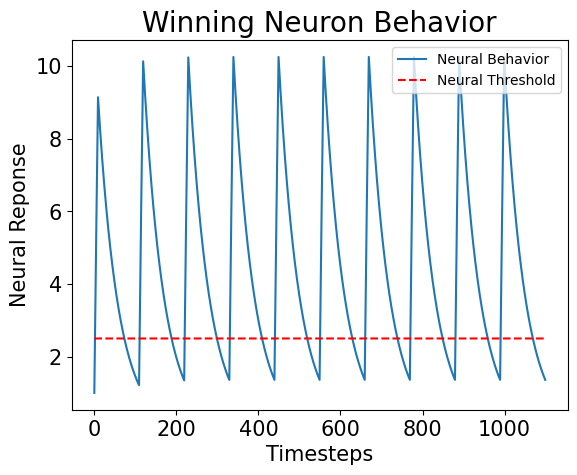

In [ ]:
# Initialize neural field

tau = 10 # Time constant
testNF = WilsonNF([],[],tau)

for cycles in range(10):
  for activated in range(10):
    # Sensors activated for 10 time steps
    sizeInput = [50,50]
    angleInput = [-90, -90]
    testNF.updateNF(sizeInput, angleInput, noiseBool = False)
  for deactivated in range(100):
    # Sensors deactivated for 100 timesteps
    testNF.updateNF([],[],noiseBool = False)

testNF.plotInputs(False)
testNF.plotOutputs(False,False)
testNF.plotMaxResp()

# 4. Kinematic Agent (virtual leech)

## 4.1 Initialization and Setter Functions

Next we create an agent object which will act as our virtual leech. The AgentNF is initialized with an *size*, starting position (*x_int*, *y_int*), a starting orientation (*o_int*), and a neural field instance (*WilsonNF*).

*self.leechSize* determines the size of the agent (*self.height* and *self.width*). These two variables represent the major and minor radii of an ellipse. It also determines the *crawlingVelocity* and the *swimmingVelocity* of the agent. These velocities are ratios of the leeches length, as found from the literature data. For now, we only use the *crawlingVelocity* to guide the agent's motion, which is stored in *self.v*.

There are three different *leechSize* inputs that can be used, "Small", "Medium", and "Large".  "Medium" is the only size based on the actual size of an adult *Hirudo* *Verbana* leech. The other two body sizes were created for research purposes.

The agent's initial position and orientation are stored in (*self.x_init*, *self.y_init*) and *self.o_init* (orientation angle is measured counterclockwise from the right/east). These variables are only used for plotting purposes and the current position and orientation of the agent are stored in (*self.x*, *self.y*) and *self.actualAngle* (measured counterclockwise from the right/east). These variable are updated through the simulation with the most recent position and orientation. The initial position and orientation can be manually set by **AgentNF.setInitialPosition(*x_init*, *y_init*, *o_init*)**.

*self.oV* stores the agent's orientation vector. It holds the x and y components for the vector in which the agent is traveling. This is used to update the agent's position in a particular direction.

The agent has a set of distributed sensors around its perimeter, mimicking the mechanosensors dispersed along the leech's skin. These virtual sensors are separated by a constant angular interval. The number of sensors matches the number of neural nodes within the neural field. For example, if there are 24 neural nodes, then there are 24 sensors separated by 15$^{\circ}$ intervals (360$^{\circ}$  / 24 = 15$^{\circ}$ ). In order to find the coordinate position of these sensors, we used the elliptical function to find points along the agent's perimeter. The positive points in the ellipse are stored in *self.coordsP* and the negative points in the ellipse are stored in *self.coordsN*. The points are geometrically translated by the agent's initial position.

The agent must start at the initial orientation, therefore we must rotate the agent during initialization.



## 4.2 Helper and Main Update Functions

- **AgentNF.getSensorEncodedAngle(*n_sensor*)** retrieves the encoded angle from each sensor. The angle is retreived from the *self.nf.encodedDirections* list by the sensor index, *n_sensor*. The angle is offset in order to map it to the current orienation of the agent. The resulting angle is measured counterclockwise from the right/east.

- **AgentNF.sensors()** generates a list of tuples of the form *(angle, (x,y), (vx, vy, vz))*, where each tuple expresses information about a sensor's preferred/encoded angle (angles increase counterclockwise from the agent's head/orientation vector), its coordinates in space, and its "sensor detection vector", which rotates with the agent. This function has two pointers, *cP* and *cN*, which point to the current positive and negative sensor (this is because the sensors were generated using the elliptical function, creating a set of positive and negative points - reference section 4.1 for more details). The for loop loops over the total number of sensors, (*self.coordsP.shape[1]*$*$2)-1. Anytime the index, *i*, is positive (*i*%2 == 0), it measures a positive sensor and if *i* is odd then it measures a negative sensor. *cN* starts at 1 to skip over the first negative sensor since it is the same as the first positive sensor. The loops cuts the last postive sensor off because it is the same of the last negative sensor.

 - To get a visual representation of the positive and negative sensors refer to section 9.1 in Extra Figures and Animations.

- **AgentNF.dist(*x1*, *y1*, *x2*, *y2*)** finds the distance between two points (x1, y1) and (x2, y2).

- **AgentNF.perimeter()** finds the approximate perimeter of the agent.

- **AgentNF.distBetweenSensors()** finds the distance between each sensor and is calculated by first calling **AgentNF.perimeter()** and dividing it by the number of sensors, *self.nf.n*.

- **AgentNF.calcAgeVector(*v*, *o*)** calculates the agent's direction vector based on the agent's velocity, *v*, and current orientation, *o* (measured counterclockwise from the right/east). It outputs a 1x3 array with x, y, and z components. Since we are working in two-dimensions the z component will always be zero.

- **WilsonNF.polVect_to_compVect(*v*, *o*)** is a helper function used to covert a polar vector into a component vector. *v* is the polar vector's magnitude and *o* is the polar vector's angular component (measured counterclockwise from the right/east).

- **AgentNF.vectorProjection(*a*, *b*)** simply projects vector *a* onto vector *b*. This is done by dividing the dot product of the two vectors by the normal of vector *b* and multiplying it by vector *b*. The projected vector is returned.

- **AgentNF.findWaterAngle(*a*, *b*)** finds the angle between two vectors, vector *a* and vector *b*. In the simulation, vector *a* refers to the sensor detection vector, which is the vector starting at the sensor position and pointing away from the agent's center. Vector *b* refers to the vector pointing from the sensor's coordinate to the target location origin. Various trigomentric functions are performed to find a resultant angle. The final angle is multiplied by the sign of the cross product between vector *a* and *b*. It is then converted from radians to degrees.

- **AgentNF.updateOrientationVector(*WilsonNF*, *n*)** rotates the agent with **AgentNF.rotateAgent()** by a specified angle calculated from **AgentNF.calcAngVel()** (positive angles rotate counterclockwise). The *self.actualAngle* is updated by adding the rotated angle (*angVel*) to it. The orientation vector is updated by converting the agent's velocity and orientation components (components of a polar vector) into a component vector using the **AgentNF.polVect_to_compVect(...)** helper function.

- **AgentNF.calcAngVel(*ang*)** is called by **AgentNF.updateOrientationVector(...)**. It calculates a turn rate from the inputted percieved angle (*ang*) using a proportional constant, *k_p*. The turn rate is scaled by the time constant. Increasing *k_p* increases the turn rate speed, which may lead to oscillatory motions. Decreasing *k_p* decreases the turn rate speed, which may cause the agent to pass the target location, making it unable to turn around in time. This constant can and should be tuned to control the agent's motion.

- **AgentNF.rotate(*coords*, *theta*)** uses a transformation matrix function to rotate the sensor coordinates, *coords*, by a specified angle, *theta* (positive angles rotate counterclockwise).

- **AgentNF.rotateAgent(*angVel*)** calls **AgentNF.rotate(...)** for both the positive and negative sensor coordinate lists.

- **AgentNF.updatePosition(*Environment*)** updates the position of the agent using the orientation vector, *self.oV*. The agent always travels along this vector, roughly mimicing the motion of a leech which crawls like an inch worm, brings its tail end to its head and extending its head forward. This function also checks to make sure the agent stays within the square boundary before updating its position.

- **AgentNF.checkInSquareBoundary(*Environment*)** checks the agent's position with the environment boundary. If the agent reaches a boundary, then it turns 180 degrees and travels in the opposite direction.

## 4.3 Plotting Functions


- **AgentNF.plotAgent(*color*)** and **AgentNF.plotAgent(*color*, *ax*)** are the exact same except the ax specifies an axis for which the plot is added to. These functions plot the agent's shape as well as a red marker to indicate its current orientation.
- **AgentNF.plotSensors()** illustrates the locations of the agent's sensors and all sensor detection vectors.

## 4.4 Agent Source Code

In [ ]:
### AGENT CLASS THAT USES A NEURAL FIELD (nf) FOR SENSORY PROCESSING

class AgentNF():
    def __init__(self,leechSize,x_int,y_int,o_int,WilsonNF,ignore_boundaries=False):

         ### STORE NEURAL FIELD

        self.nf = WilsonNF

        ### AGENT'S SIZE AND SPEED BASED ON AGE

        self.leechSize = leechSize
        if leechSize == "Medium" or leechSize == "Adult":
            # Initialize agent size based on age type
            self.height = 10/2 # height = 2 cm, minor radius
            self.width = 1/2
            self.r = 1
            crawlingVelocity = (10/6.4) * (self.nf.tau/1000)
            swimmingVelocity = (self.height/.66) * (self.nf.tau/1000)
        elif leechSize == "Large":
          # Initialize agent size based on age type
            self.height = 30/2 # height = 2 cm, minor radius
            self.width = 3/2
            self.r = 1
            crawlingVelocity = (10/6.4) * (self.nf.tau/1000)
            swimmingVelocity = (self.height/.66) * (self.nf.tau/1000)
        elif leechSize == "Small":
          # Initialize agent size based on age type
            self.height = 3.33/2 # height = 2 cm, minor radius
            self.width = (1/3)/2
            self.r = 1
            crawlingVelocity = (10/6.4) * (self.nf.tau/1000)
            swimmingVelocity = (self.height/.66) * (self.nf.tau/1000)
        else:
            # Need to add adolescents and juveniles
            self.height = 5 # height = 2 cm, minor radius
            self.width = 5
            self.r = 1
            crawlingVelocity = (10/6.4) * (self.nf.tau/1000)
            swimmingVelocity = (self.height/.66) * (self.nf.tau/1000)

        self.v = crawlingVelocity #Agent has constant velocity for now

        ### STORE AGENT'S INITIAL POSITION AND ORIENTATION

        self.x_init = x_int
        self.y_init = y_int
        self.o_init = o_int

        ### STORE AGENT'S CURRENT POSITION AND ORIENTATION
        # (These variables are updated throughout the simulation)

        self.x = x_int
        self.y = y_int
        self.o = o_int
        self.deltaAngle = o_int*(pi/180) # Change in orientation
        self.actualAngle = o_int*(pi/180) # True orientation

         # oV is the agent's orientation vector ([x,y,z]) - used in the update position function
        self.oV = [self.v*cos(self.actualAngle), self.v*sin(self.actualAngle), 0]

        ### SENSOR COORDINATE POSITIONS RELATIVE TO AGENT POSITION

        # This block of code is used to plot an circular/elliptical shaped agent
        # which also sets the positions of the sensors evenly spaced around the perimeter

        # self.nf.n sets number of sensors equal to number of neural nodes
        self.x_coords = np.linspace(-self.height,self.height,int((self.nf.n/2)+1))
                                    # int(w.n_spaces))
        self.yP_coords = np.sqrt((self.width**2)*((self.r**2)-((self.x_coords**2)/(self.height**2))))
        self.yN_coords = -np.sqrt((self.width**2)*((self.r**2)-((self.x_coords**2)/(self.height**2))))
        self.coordsP = np.array([[self.x_coords], # Position values in the ellipse
                                 [self.yP_coords]])
        self.coordsN = np.array([[self.x_coords], # Negative values in the ellispse
                                 [self.yN_coords]])

        # Set agent's initial position
        self.coordsP[0] = self.coordsP[0]+self.x
        self.coordsP[1] = self.coordsP[1]+self.y
        self.coordsN[0] = self.coordsN[0]+self.x
        self.coordsN[1] = self.coordsN[1]+self.y
        self.coordsP = self.coordsP.reshape((2,len(self.x_coords)))
        self.coordsN = self.coordsN.reshape((2,len(self.x_coords)))

        ### MOTION CONTROL INITIALIZATION

        self.ignore_boundaries = ignore_boundaries

        # Rotate agent based on initial orientation
        self.rotateAgent(self.actualAngle)

        self.count = 30 # Number of times the agent is inside the target location

    ### SETTER AND GETTER FUNCTIONS

    def setInitialPosition(self,x_init,y_init,o_init):

      self.x_init = x_init
      self.y_init = y_init
      self.o = o_init
      self.rotateAgent(o_init*(pi/180))
      return self.x_init, self.y_init,self.o

    ### HELPER FUNCTIONS

    def getSensorEncodedAngle(self, n_sensor):

      # Use list of encoded angles from neural field to find specific sensor angle
      angleTransformation = self.nf.encodedAngles + pi  # JPG 2024-07-18 add pi to shift [-180, ..., +180) to [0, ..., +360)
      # Transform the angle with the agent's current orientation and
      # use n_sensor as an index
      encodedAngle = ((angleTransformation+self.actualAngle)*(180/pi))[n_sensor]
      return encodedAngle

    def sensorVector(self,v,theta):
      theta = theta*(pi/180)
      x = v*cos(theta)
      y = v*sin(theta)
      return x,y,0

    def sensors(self):
        cP, cN = 0, 1 # Positive and negative sensor pointers
        for i in range((self.coordsP.shape[1]*2)-1):
            ### Positive elliptical points
            if i%2 == 0 and i != (self.coordsP.shape[1]*2)-2:
                sensorAngle = self.getSensorEncodedAngle(cP)
                x = self.coordsP[0,-cP-1]
                y = self.coordsP[1,-cP-1]
                cP+=1

            ### Negative elliptical points
            elif i%2 != 0 or i == (self.coordsP.shape[1]*2)-1:
                sensorAngle = self.getSensorEncodedAngle(-cN)-360
                x = self.coordsN[0,-cN-1]
                y = self.coordsN[1,-cN-1]
                cN+=1

            else: continue

            relativeAngle = sensorAngle-(self.actualAngle*(180/pi))
            sensorVector = self.sensorVector(100, sensorAngle)
            yield (relativeAngle, (x, y), sensorVector)

    def dist(self,x1,y1,x2,y2):
      # Find distance between two points

      return  math.sqrt(((x1-x2)**2) + ((y1-y2)**2))

    def perimeter(self):
      a,b = self.height,self.width
      neg, pos = (a-b)**2, (a+b)**2
      numerator = 3*neg
      denominator = pos*(np.sqrt((-3*(neg/pos)+4))+10)
      C = pi*(a+b)*((numerator/denominator)+1)
      return C

    def distBetweenSensors(self):

      C = self.perimeter()
      return C/self.nf.n

    # def calcAgeVector(self,v,o):  # JPG 2024-04-10 this is unused
    #     # Find an orientation vector based on agent's velocity (v)
    #     # and current orientation (o)

    #     if not o:
    #         o = 0
    #     theta = o
    #     x_dir = v*cos(theta)
    #     y_dir = v*sin(theta)
    #     z_dir = 0
    #     return [x_dir, y_dir, z_dir]

    def polVect_to_compVect(self,v,o):
        # Helper function to convert polar vector to component vector

        compVect = np.zeros(3)
        compVect[0] = v*cos(o)
        compVect[1] = v*sin(o)
        compVect[2] = 0
        return compVect

    def vectorProjection(self,a,b):
        # Projection of vector a onto vector b

        num = np.dot(a,b)
        dem = b[0]**2 + b[1]**2
        return np.multiply((num/dem),b)

    def findWaterAngle(self,a,b):

        num = np.dot(a,b)
        normA = np.linalg.norm(a)
        normB = np.linalg.norm(b)
        dem = normA*normB

        if (1-(num/dem)) < .0000001:
            n_m = 1
        elif (1+(num/dem)) < .000001:
            n_m = -1
        else:
            n_m = num/dem

        theta = math.acos(n_m)
        q = np.cross(a,b)

        angle = theta*(np.sign(q[2]))
        return angle*(180/math.pi)

    ### UPDATE FUNCTIONS USED TO CHANGE AGENT'S ORIENTATION

    def updateOrientationVector(self,n):
        # Update orientation vector based on percieved angle from the neural field

        self.deltaAngle = n*(pi/180)
        # angularVel = self.calcAgeVector(self.v,self.actualAngle)  # JPG 2024-04-10 this is unused
        angVel = self.calcAngVel(self.deltaAngle)
        self.actualAngle = self.actualAngle + angVel
        self.oV = self.polVect_to_compVect(self.v,self.actualAngle)
        self.rotateAgent(angVel) # Once orientations are updated, rotate
        return self.oV

    def calcAngVel(self,ang):

        k_p = .4
        angVel = (k_p * ang)
        return angVel * (self.nf.tau/1000)

    def rotate(self,coords,theta):
        # 2D rotation matrix function used to rotate ellipse

        if not theta:
            theta = 0
        mid = np.array([[(coords[0,-1]+coords[0,0])/2],
                        [(coords[1,-1]+coords[1,0])/2]])
        # Make the midpoint the origin
        coords_mid = coords - mid
        trans = np.array([[cos(theta), -sin(theta)],
                          [sin(theta), cos(theta)]])
        rotated = np.dot(trans,coords_mid)
        # Add the midpoint coordinates to return to previous origin
        rotated = rotated + mid
        return rotated

    def rotateAgent(self,angVel):

        self.coordsP = self.rotate(self.coordsP,angVel)
        self.coordsN = self.rotate(self.coordsN,angVel)

    def updatePosition(self,Environment):

        if not self.ignore_boundaries:
            self.checkInSquareBoundary(Environment)
        self.x = self.x + self.oV[0]
        self.y = self.y + self.oV[1]
        self.coordsP[0] = self.coordsP[0]+self.oV[0]
        self.coordsP[1] = self.coordsP[1]+self.oV[1]
        self.coordsN[0] = self.coordsN[0]+self.oV[0]
        self.coordsN[1] = self.coordsN[1]+self.oV[1]
        return [self.x, self.y, 0]

    def checkInSquareBoundary(self,Environment):
        # Need to fix bugs in this function
        # Goal is to have agent turn along boundary and move along it instead of turning 180 degrees upon impact

        e = Environment
        if abs(self.x - (e.x*2)) < self.v or abs(self.x - 0) < self.v:
            # Impact detector on horizontal walls
            self.oV[0] = -self.oV[0]
            self.deltaAngle = pi
            self.actualAngle = self.actualAngle+self.deltaAngle
            self.rotateAgent(self.deltaAngle)
        elif abs(self.y - (e.y*2)) < 1 or abs(self.y - 0) < 1:
            # Impact detector on vertical walls
            self.oV[1] = -self.oV[1]
            self.deltaAngle = pi
            self.actualAngle = self.actualAngle+self.deltaAngle
            self.rotateAgent(self.deltaAngle)

    ### PLOTTING FUNCTIONS

    def plotCurrentPosition(self, color):

         plt.scatter(self.x, self.y, c = color)

    def plotAgent(self,color):

        plt.plot(self.coordsP[0],self.coordsP[1],self.coordsN[0],self.coordsN[1],color=color) # Agent body
        plt.scatter(self.coordsP[0][-1],self.coordsP[1][-1],c='black',s=40,marker='o',zorder = 20) # Agent orientation marker

    def plotAgentAx(self,color,ax):

        ax.plot(self.coordsP[0],self.coordsP[1],self.coordsN[0],self.coordsN[1],color=color) # Agent body
        ax.scatter(self.coordsP[0][-1],self.coordsP[1][-1],c='black',s=40,marker='o',zorder = 20) # Agent orientation marker

    def plotSensors(self, ax=None, sensor_distortions={}):
        if ax == None:
            ax = plt.gca()

        for i, (relativeAngle, (x,y), (vx, vy, _)) in enumerate(self.sensors()):
            sensor_distortion = sensor_distortions.get(round(relativeAngle), {})

            arrow_scale = 1/100*self.height/5
            arrow_start = (x, y)
            arrow_end = (x + vx*arrow_scale, y + vy*arrow_scale)

            if sensor_distortion == {}:
                ### NON-DISTORTED SENSOR
                ### Plot the detection vector of the non-distorted sensor using
                ### a black arrow with v-head
                arrow_style = '<-'
                arrow_color = 'k'
                arrow_props = dict(arrowstyle=arrow_style, color=arrow_color, ls='-')
                ax.annotate(text='', xy=arrow_start, xytext=arrow_end, arrowprops=arrow_props, zorder=10)

            elif ('multiplierConstant' in sensor_distortion and
                  'additiveConstant' not in sensor_distortion and
                  'additiveRandomNormal' not in sensor_distortion):
                ### AMPLIFIED SENSOR: MULTIPLIER CONSTANT ONLY
                ### Plot the amplified sensor as a green (multiplier>1) or red
                ### (multiplier<1) bold arrow with filled head, or a red x
                ### (multiplier=0, ablation)
                multiplierConstant = sensor_distortion['multiplierConstant']
                arrow_style = '<|-'
                if multiplierConstant == 0:
                    # ablation
                    ax.scatter(x, y, color='r', marker='x', s=10, zorder=20)
                    continue
                elif multiplierConstant > 1:
                    arrow_color = 'g'
                elif multiplierConstant < 1:
                    arrow_color = 'r'
                else:
                    # equal to 1, equivalent to non-distorted
                    arrow_color = 'b'
                arrow_props = dict(arrowstyle=arrow_style, color=arrow_color, ls='-', lw=2)
                ax.annotate(text='', xy=arrow_start, xytext=arrow_end, arrowprops=arrow_props, zorder=10)

            elif ('additiveConstant' in sensor_distortion and
                  'multiplierConstant' not in sensor_distortion and
                  'additiveRandomNormal' not in sensor_distortion):
                ### BIASED SENSOR: ADDITIVE CONSTANT ONLY
                ### Plot the detection vector of the biased sensor using a green
                ### (positive bias) or red (negative bias) non-bold arrow with
                ### filled head
                additiveConstant = sensor_distortion['additiveConstant']
                arrow_style = '<|-'
                if additiveConstant > 0:
                    arrow_color = 'g'
                elif additiveConstant < 0:
                    arrow_color = 'r'
                else:
                    # equal to 0, equivalent to non-distorted
                    arrow_color = 'b'
                arrow_props = dict(arrowstyle=arrow_style, color=arrow_color, ls='-')
                ax.annotate(text='', xy=arrow_start, xytext=arrow_end, arrowprops=arrow_props, zorder=10)

            elif ('additiveRandomNormal' in sensor_distortion and
                  'multiplierConstant' not in sensor_distortion and
                  'additiveConstant' not in sensor_distortion):
                ### NOISY SENSOR: ADDITIVE RANDOM NORMAL ONLY
                ### Plot the detection vector of the noisy sensor using a blue
                ### (mean=0), green (mean>0), or red (mean<0) bar whose width
                ### increases with sd
                from matplotlib.patches import ArrowStyle
                noise = sensor_distortion['additiveRandomNormal']
                arrow_style = ArrowStyle.BracketA(widthA=0.5*np.log(noise['sd']+1), lengthA=0, angleA=0)
                if noise['mean'] > 0:
                    arrow_color = 'g'
                elif noise['mean'] < 0:
                    arrow_color = 'r'
                else:
                    # mean of 0
                    arrow_color = 'b'
                arrow_props = dict(arrowstyle=arrow_style, color=arrow_color, ls='-')
                ax.annotate(text='', xy=arrow_start, xytext=arrow_end, arrowprops=arrow_props, zorder=10)

            else:
                ### COMPLEX DISTORTION: A COMBO OF TYPES GIVEN
                ### Plot the detection vector of the complexly distorted sensor
                ### using a magenta arrow with v-head
                arrow_style = '<-'
                arrow_color = 'm'
                arrow_props = dict(arrowstyle=arrow_style, color=arrow_color, ls='-')
                ax.annotate(text='', xy=arrow_start, xytext=arrow_end, arrowprops=arrow_props, zorder=10)

In [ ]:
### TEST SENSOR DISTORTION MARKERS

refAgent = AgentNF('Medium', 0, 0, 90, WilsonNF([],[],10))
xlim, ylim = refAgent.width*3, refAgent.height*1.5

# angles listed start from rear, going counterclockwise
sensor_distortions = {
    -180: {},
    -165: {},

    # green bars
    -150: {'additiveRandomNormal': {'mean': 1, 'sd': 2}},
    -135: {'additiveRandomNormal': {'mean': 1, 'sd': 1}},
    -120: {'additiveRandomNormal': {'mean': 1, 'sd': 0.5}},

    # blue bars
    -105: {'additiveRandomNormal': {'mean': 0, 'sd': 2}},
    -90: {'additiveRandomNormal': {'mean': 0, 'sd': 1}},
    -75: {'additiveRandomNormal': {'mean': 0, 'sd': 0.5}},

    # red bars
    -60: {'additiveRandomNormal': {'mean': -1, 'sd': 2}},
    -45: {'additiveRandomNormal': {'mean': -1, 'sd': 1}},
    -30: {'additiveRandomNormal': {'mean': -1, 'sd': 0.5}},

    -15: {},

    # red x
    0: {'multiplierConstant': 0},

    # red bold arrow with filled head
    15: {'multiplierConstant': 0.5},

    # blue bold arrow with filled head
    30: {'multiplierConstant': 1},

    # green bold arrow with filled head
    45: {'multiplierConstant': 2},

    60: {},
    75: {},

    # red non-bold arrow with filled head
    90: {'additiveConstant': -1},

    # blue non-bold arrow with filled head
    105: {'additiveConstant': 0},

    # green non-bold arrow with filled head
    120: {'additiveConstant': 1},

    135: {},

    # magenta arrow
    150: {'multiplierConstant': 1, 'additiveConstant': 0},

    165: {},
}

plt.figure()
ax = plt.gca()
ax.set_axis_off()
ax.set_xlim([-xlim+refAgent.x, xlim+refAgent.x])
ax.set_ylim([-ylim+refAgent.y, ylim+refAgent.y])
ax.set_aspect('equal')
refAgent.plotAgentAx(ax=ax, color='black')
refAgent.plotSensors(ax=ax, sensor_distortions=sensor_distortions)

## 4.5 Example Agent

We will use the testNeuralField as an input for the testAgent. In this demo we build upon the code written from section 3.4. In the for loops controlling when the sensors recieve inputs, the agent's orientation vector and position are updated as well. At each timestep, the agent's current position is plotted within a sample behavioral arena. NOTE: The agent is not sensing anything and is only responsding to the [-90, -90] (right turn) and [90, 90] (left turn) inputs, creating an oscillatory motion. The agent is not supposed to be navigating towards the target location. The behavioral arena is shown to provide a sense of scale for example purposes.

Also note that plotting the agent's position at each time step is extremely inefficient. The best practice for displaying a trajectory plot is storing the positions of the agent at each timestep and plotting the data as a set of x and y lists. This is done later in the simulation code (section 6).

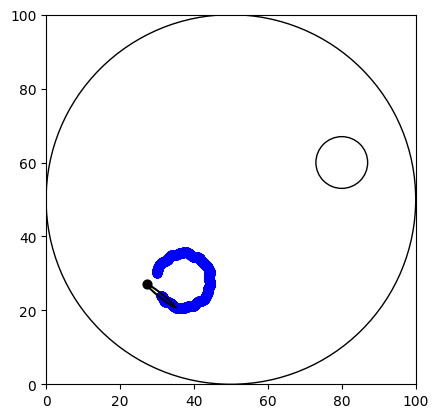

In [ ]:
### Initialize the environment and neural field

testEnvironment = Environment(50, 50, 50, 90)
testEnvironment.setTargetLocation(80, 60)

tau = 10 # Time constant
testNF = WilsonNF([],[],tau)

### Initialize the agent

age, x_int, y_int, o_int = 'Medium', 30, 30, 90
testAgent = AgentNF(age, x_int, y_int, o_int, testNF)

### Using the code written in section 3.3, we can attach the neural field to the
### agent and use its outputs to control the agent's turn rate.

# First lets reset the values in the neural field
testNF.resetVals()
testEnvironment.plotEnv()

for cycles in range(10):
  for activated in range(200):
    # Sensors activated for 10 time steps
    sizeInput = [12,12]
    if cycles % 2  == 0:
      angleInput = [-90, -90]
    else:
      angleInput = [90, 90]

    perceived = testNF.updateNF(sizeInput, angleInput, noiseBool = False)

    # Update the agent's orientation vector and position each timestep
    if len(perceived) != 0:
      testAgent.updateOrientationVector(perceived[0])
      testAgent.updatePosition(testEnvironment)

      testAgent.plotCurrentPosition('blue')

  for deactivated in range(200):
    # Sensors deactivated for 100 timesteps
    perceived = testNF.updateNF([],[],noiseBool = False)

    # Update the agent's orientation vector and position each timestep
    if len(perceived) != 0:
      testAgent.updateOrientationVector(perceived[0])
      testAgent.updatePosition(testEnvironment)

      testAgent.plotCurrentPosition('blue')

testAgent.plotAgent('black')
# testAgent.plotSensors()

# testNF.plotInputs(False)
# testNF.plotOutputs(False,False)

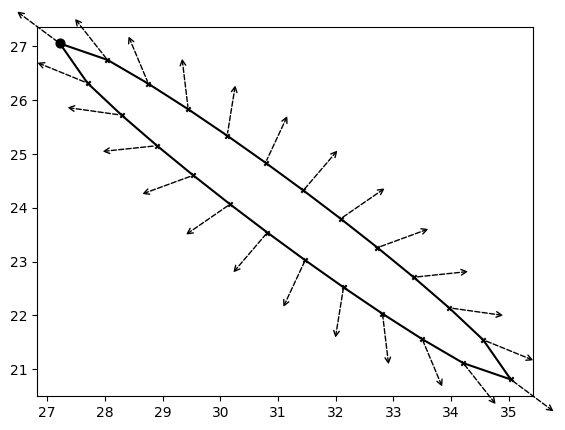

In [ ]:
plt.figure()
testAgent.plotAgent('black')
testAgent.plotSensors()

# 6. Water waves

## 6.1 Initialization

The water waves used in this simulation are 2D point surface waves with motions behaving according to the dispersion relation. The Wave object is initialized with an *environment* instance, *frequency* input, and a *depth* input. The wave propogates away from an origin point which is set by the *environemnt* instance.

First the water wave's physical parameters are set. NOTE: All parameters with a unit of length use cm as their units. The amplitude, *self.a*, is set according to the wave amplitude measurement from Harley's 2011 study. Input *frequency* in terms of hertz and *depth* in terms of meters.

Next, we define the physical space that the wave propagates over. The size of the space is set according to the environment. The *pixels* value sets the density of points within the space. We use **np.meshgrid(*x*, *y*)** to create a rectagular grid out of two one-dimensional arrays. This function is very useful for two-dimentional plotting.

Next we use **fsolve()** and the dispersion relation equation to solve for wavelength as a function of the input wave frequency. We can then solve for the wavenumber (*self.k*) and the spatial frequency (*self.w*). For more information on the dispersion relation please reference [dispersion relation](https://en.wikipedia.org/wiki/Dispersion_(water_waves).

Finally a matrix, *self.z*, is initialized to store the wave surface elevation output at each point in the environment.









## 6.2 Helper and Main Update Functions

- **Wave.norm(*x*, *y*)** normalizes the vector pointing from point the stimulus origin (*self.x_center*, *self.y_center*) to a given point (*x*, *y*). It does this via the distance function.

- **Wave.waterSurfaceElevation(*x*, *y*, *t*)** calls the wave propagation function for a single point, (*x*, *y*) at time *t* to determine its elevation.

- **Wave.theta(*x*, *y*, *t*)** calculates the phase function for the propagation equation and calls the **Wave.norm(...)** for the entire set of x, y coordinate points in the environment.

- **Wave.update(*t*)** calls **Wave.waterSurfaceElevation(...)** in order to find the wave elevation at each input time *t*. The elevations are stored in the surface elevation matrix, *self.z*.



## 6.3 Plotting Functions

The two plotting functions do the same thing, except one takes in an axis parameter, *ax*, to plot on specific figures. **Wave.plotWave()** creates a density plot based on the outputted surface elevations at time, *t*. It uses **plt.pcolormesh()** which can be easily customized, i.e., change the plot color.

## 6.4 Water Wave Source Code

In [ ]:
class Wave():
    def __init__(self,environment,frequency,depth,pixels=200):

        ### PHYSICAL PROPERTIES OF THE WAVE

        self.g = 9.8*100 # gravitational constant
        self.foot_radius = 4.7/2  # = 2.35 cm, from Harley et al. 2011
        self.A1 = 0.4 * np.sqrt(self.foot_radius + 3)  # = 0.925203 cm^(3/2), to get 0.4-cm waves 3 cm from foot, as in Harley et al. 2011
        self.frequency = frequency # frequency in hertz (1/seconds)
        self.T = 1/frequency # time period of wave
        self.h = depth*100 # depth of water input in meters, but convert h to centimeters here so wavelength calculations produce centimeters

        ### SPATIAL COMPONENTS OF THE WAVE

        # Define x,y space the wave propagates over, in this case it is a square
        size = environment.x
        x = np.linspace(0,size*2,pixels)
        y = np.linspace(0,size*2,pixels)
        self.e = environment
        self.x_center = self.e.xG
        self.y_center = self.e.yG
        self.x,self.y = np.meshgrid(x,y)


        ### DISPERSION RELATION

        # Starting with the dispersion relation,
        #   omega^2 = g * k * tanh(k*h),
        # we substitute omega=2*pi*f and k=2*pi/lambda
        #   (2*pi*f)^2 = g * 2*pi/lambda * tanh(2*pi*h/lambda)
        # and then rearrange terms in a series of steps:
        #   2*pi * f^2 = g / lambda * tanh(2*pi*h/lambda)
        #   lambda = g/(2*pi) * 1/f^2 * tanh(2*pi*h/lambda)
        #   0 = g/(2*pi) * 1/f^2 * tanh(2*pi*h/lambda) - lambda
        # Because lambda is a reserved keyword in Python, we use x for
        # wavelength below and then solve for the roots in x using fsolve.

        # Relates wavelength to water depth and wave frequency
        func_solve = lambda x,f,h : (self.g/(2*pi))*((1/f)**2)*np.tanh(2*pi*h/x) - x
        lambda_func = lambda x : func_solve(x,self.frequency,self.h)
        self.wavelength = fsolve(lambda_func,1)[0]
        self.k = (2*pi)/(self.wavelength)
        self.w = np.sqrt(self.g*self.k*math.tanh(self.k*self.h)) # Angular frequency

        ### OUTPUT STORAGE MATRIX FOR WATER ELEVATION VALUES

        self.z = np.zeros((len(x),len(y))) # Water elevation matrix

    ### HELPER FUNCTIONS

    def norm(self, x, y):
        d = np.sqrt((x - self.x_center)**2 + (y - self.y_center)**2)
        d = np.maximum(self.foot_radius, d)
        return d

    def amplitude_envelope(self, x, y):
        return self.A1 / np.sqrt(self.norm(x, y))

    def waterSurfaceElevation(self, x, y, t):
        return self.amplitude_envelope(x, y) * np.sin(self.theta(x, y, t))

    ### MAIN UPDATE FUNCTIONS

    def theta(self,x,y,t):

        R = self.norm(x,y)
        return (self.k*R)-self.w*t

    def update(self,t):

        self.z = self.waterSurfaceElevation(self.x,self.y,t)
        return self.z

    ### PLOT FUNCTION

    def plotWaveAx(self,ax):

        max_amplitude = self.amplitude_envelope(self.x_center, self.y_center)
        normalize = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
        im = ax.pcolormesh(self.x,self.y,self.z,norm=normalize)
        ax.set_aspect('equal')
        return im

    def plotWave(self):

        max_amplitude = self.amplitude_envelope(self.x_center, self.y_center)
        normalize = matplotlib.colors.Normalize(vmin=-max_amplitude, vmax=max_amplitude)
        im = plt.pcolormesh(self.x,self.y,self.z,norm=normalize)
        plt.gca().set_aspect('equal')
        return im

    def plotWaveCrossSection(self, t=0, xmax=100, n=2000, ymin=-0.75, ymax=0.75):
        d = np.linspace(0, xmax, n)
        a = w.amplitude_envelope(w.x_center + d, w.y_center)
        y = w.waterSurfaceElevation(w.x_center + d, w.y_center, t)
        ax = plt.gca()
        ax.plot([0, xmax], [0, 0], c='k')  # plot the y=0 line
        ax.plot(d, a, c='lightgray')       # plot the upper envelope
        ax.plot(d, -a, c='lightgray')      # plot the lower envelope
        ax.plot(d, y)                      # plot the wave
        ax.set_xlabel('Distance from goal (cm)')
        ax.set_ylabel('Wave amplitude (cm)')
        ax.margins(0)
        ax.set_ylim(ymin, ymax)

## 6.5 Water Wave Example and Animation

Let's create a water wave placed in the test environment from section 2.3.

In [ ]:
### Initialize environment

testEnvironment = Environment(50, 50, 50, 90)
testEnvironment.setTargetLocation(80, 60)

### Initialize Wave

frequency, depth = 4, 1
w = Wave(testEnvironment, frequency, depth)
w.update(1) # Update for one timestep to generate motion

### Plot Wave
w.plotWave()
bar = plt.colorbar() # add color bar

In [ ]:
### Plot Wave Cross-Section
w.plotWaveCrossSection(t=0)

In [ ]:
### Water wave animation

### CONFIGURE TIME PARAMETERS

t = 2 # Total animation time in seconds
fps = 30 # Frames per second
tau = 1000 / fps # 16.67 for fps of 60, 33.3 for fps of 30, 100 for fps of 10
numFrames = int(np.round(t/(tau/1000))) # Number of updates that occur

### INITIALIZE WATER WAVE FOR THE ANIMATION
frequency, depth = 8, .01
waterAnimation = Wave(testEnvironment, frequency, depth)

### SET UP FIGURE FOR ANIMATION
figWave,axWave = plt.subplots()

def update(frame):
  plt.cla() # Clear plot every frame to reduce lag
  timet = frame*(tau/1000) # Convert frame number to real time
  k = waterAnimation.update(timet) # Update with real time
  waterFrame = waterAnimation.plotWaveAx(axWave) # Plot wave

line_ani = animation.FuncAnimation(
    figWave, update, frames = numFrames, interval=tau)

from IPython.display import HTML
HTML(line_ani.to_html5_video())

#7. Simulation

## 7.1 Initialization and Setter Functions

The Simulation object accepts a two inputs: a list of *components* and a list of *parameters*. The *components* list comprises of an environment instance, *self.env*, a neural field instance, *self.nf*, and an agent instance, *self.agent*. The initial conditions for the agent are stored in a separate list, *self.agent_init*. This is used in the reset functions.

Next, the *parameters* are stored into variables, *self.frequency*, *self.h* (wave depth in meters), *self.numFrames*, and *self.tau*. Use **Simulation.setFrequency(*n*)** and **Simulation.setDepth(*n*)** to update the frequency and water depth to easily test the affect of different water waves on navigational behavior (as shown in section 7.4).

Since we are testing the impact of wave frequency and water depth on navigational behavior, these variables act as direct inputs for the simulation. Therefore, we create an instance of a water wave within the simulation initialization. It is stored in *self.waterWave*.

There are three storage matrices: two used to hold all of the sensory inputs at each timestep (*self.sizes* for the magnitudes and *self.angles* for the directions) and one matrix to store the agent's positions, *self.positions*, at each timestep. Column 0 stores the agent's x positions and column 1 stores the agent's y positions. The agent's initial position is added to the matrix at timestep zero.

There are three additional variables: *self.frame* which stores the simulation's current frame, and a binary flag, *self.success*, indicating whether the agent succesfully reaches the target location for a specific amount of time, *self.findTime*, in seconds.

## 7.2 Helper and Main Update Functions

- **Simulation.resetVals()** should be called anytime a new simulation is performed. It moves the agent back to its starting position, clears the storage matrices (ensure to save the data before resetting), and sets *self.time* back to zero.

- **Simulation.sensorVector()** calculates the sensor detection vector using a magnitude,*v*, and a direction, *theta*, as inputs. It returns the x, y, and z vector components.

- **Simulation.run()** calls and iterates over **Simulation.update(...)** and checks if the agent has reached the target location or not. Two lists are created two hold the time (in seconds) at which the sensors are turned on, *activatedFrames*, and the time at which the sensors are turned off. The *active_deactiveFlag* acts as a control switch, signaling when to turn the sensors on or off. It proceeds to loop over the update function for a total number of frames, *self.numFrames*. At each timestep the function checks if the agent is within 3 cm of the target location. If it stays inside for a certain amount of time, *self.findTime*, then the function returns a success. If not, then the loop continues until it exceeds the maximum time limit and returns a failure.

- **Simulation.update(*activeFrames*, *active_deactiveFlag*)** performs the sensor, neural field, and agent motion updates. When the sensors are activated, this function calls **Simulation.updateSensors()** and all of the sensors detect new activation magnitudes which are saved to the *self.sizes* list, along with sensor encoded angles stored in the *self.angles* list (angles increase counterclockwise from the agent's head/orientation vector). It sends the newly sensed information to the neural field for sensory processing by calling **self.nf.updateNF(...)**, and retrieves a list of perceived directions (again angles increase counterclockwise from the agent's head/orientation vector). It then calls **Simulation.updateAgentMotion()** to update the agent's orientation and position. When the sensors are deactivated the sensors do not collect any sensory information and it updates the neural field with blank inputs. It still updates the agent's motion when the sensors are deactivated.

- **Simulation.updateSensors()** loops over all of the sensors located around the agent's perimeter and retrieves each sensory activation magnitude and encoded direction with **Simulation.updateSingleSensor(...)** (angles increase counterclockwise from the agent's head/orientation vector).

- **Simulation.updateSingleSensor(*i*, *relativeAngle*, *x*, *y*, *sensorVector*)** takes in one-by-one the enumerated outputs of **self.agent.sensors()**, i.e., a sensor index, the encoded angle of the sensor relative to the head/orientation vector, the sensor's coordinates in the environment, and its sensor detection vector. The purpose of this function is to compute and store sensory activation magnitudes and encorded directions. We find the direction of the stimulus by calculating the angle between the oncoming stimulus and the sensor detection vector. The function calculates the water stimulus vector, *waterVector*, which points from the sensor's position, (*x*, *y*) to the stimulus origin, (*self.env.xG*, *self.env.yG*). This vector is scaled by the water wave's wavenumber, *self.waterWave.k* (in centimeters), which itself is scaled down by a factor of 0.4 (this scalar is arbitrary but can be thought of as a neural transduction factor). The function then calls **self.agent.findWaterAngle(...)** to find the angle between the *sensorVector* and the *waterVector*. If the angle is within the sensor's range of detection (within $\pm$90$^\circ$) then *waterVector* is projected onto *sensorVector*. It stores the magnitude of this projected vector, which is the activation of the sensor, in the *self.sizes* array. We then store the *relativeAngle* in the *self.angles* array.

 - To get a visual reference for all of the mentioned vectors please look at the figure from section 9.2.

- **Simulation.updateAgentMotion(*perceived*)** takes in a list of perceived directions, *perceived* (angles increase counterclockwise from the agent's head/orientation vector). If the list is empty then it updates the agent's orientation by a random turn rate. The agent has a 50% change of moving in that direction. This is meant to simulate a decrease in movement as the stimulus weakens. If *perceived* is not empty then it chooses an angle from the list at random and stores it in *turnAngle*. (An overstimulated neural field will return most of its encoded angles since almost every node will have an activation above the threshold resulting in virtually random motion. An understimulated neural field will return mainly empty lists, which also results in random motion. This is why the leech may only respond preferentially to a specfic range of wave frequencies.) If *turnAngle* is greater than 5 (this can be set to any value but we used 5 for now) then it updates the agent's orientation and position. If it's less than 5, it indicates that the neural field thinks the agent is already on right trajectory (this may not always be the case) and just the agent's position updates.



## 7.3 Plotting functions

- **Simulation.plotTrajectory()** plots the agent's positions stored in the *self.positions* array. It also plots one frame of the water wave which is purely for visual purposes. It plots the agent's starting position as a black x and the goal location as a cross.

## 7.4 Simulation Source Code

In [ ]:
class Simulation():
    def __init__(self,components,parameters):

      ### SET COMPONENT INSTANCES TO VARIABLES

      self.env = components[0]
      self.nf = components[1]
      self.agent = components[2]
      self.agent_init = [self.agent.leechSize,self.agent.x,self.agent.y,self.agent.o,self.agent.nf,self.agent.ignore_boundaries]

      ### SET PARAMETER VALUES TO VARIABLES

      self.frequency = parameters[0] # Wave frequency
      self.h = parameters[1] # Water depth (m)
      self.numFrames = parameters[2] # frames
      self.tau = parameters[3] # Time constant
      if len(parameters) > 4:
        self.sensor_distortions = parameters[4]
      else:
        self.sensor_distortions = {}

      ### INITIALIZE WATER WAVE USEING FREQUENCY AND DEPTH INPUTS

      self.waterWave = Wave(self.env,self.frequency,self.h)

      ### STORAGE ARRAYS AND MATRICES

       # Matrix to store sensory magnitudes (sizes) at each timestep
      self.sizes = np.zeros(((self.agent.coordsP.shape[1]*2)-1,self.numFrames+2))
      # Matrix to store sensory directions (angles) at each timestep
      self.angles = np.zeros(((self.agent.coordsP.shape[1]*2)-1,self.numFrames+2))
      # Array to store agent's position at each timestep (used for trajectory plots)
      self.positions = np.zeros((self.numFrames+2,2))
      self.positions[0,:] = [self.agent.x,self.agent.y] # Set initial agent position

      ### EXTRA VARIABLES

      self.frame = 0 # Keep track of frame number within simulation
      self.success = 0 # Set to 0 for failed navigational trial and 1 for successful trial
      self.findTime = 5 # Numer of seconds the agent must stay in the target location for a successful trial

      # Variables used to control how long sensors are turned on (timeOn) and off (timeOff)
      # Default set to 2 and 6 seconds (converted to frame number)
      self.timeOn, self.timeOff = 2/(self.tau/1000), 6/(self.tau/1000)

    ### SETTER FUNCTIONS

    def setFrequency(self,n):

      self.frequency = n
      self.waterWave = Wave(self.env,self.frequency,self.h)
      return self.frequency

    def setDepth(self,n):

      self.h = n
      self.waterWave = Wave(self.env,self.frequency,self.h)
      return self.h

    def setPixels(self, pixels):

      self.waterWave = Wave(self.env, self.frequency, self.h, pixels=pixels)
      return pixels

    def setSensorActivationTime(self, active, deactive):

      self.timeOn = active/(self.tau/1000)
      self.timeOff = deactive/(self.tau/1000)
      return self.timeOn, self.timeOff

    ### HELPER FUNCTIONS

    def resetVals(self):

      self.sizes = np.zeros(((self.agent.coordsP.shape[1]*2)-1,self.numFrames+2))
      self.angles = np.zeros(((self.agent.coordsP.shape[1]*2)-1,self.numFrames+2))
      self.positions = np.zeros((self.numFrames+2,2))
      self.agent = AgentNF(self.agent_init[0],self.agent_init[1],self.agent_init[2],self.agent_init[3],self.agent_init[4],ignore_boundaries=self.agent_init[5])
      self.nf.resetVals()
      self.frame = 0

    def sensorVector(self,v,theta):

      theta = theta*(pi/180)
      x = v*cos(theta)
      y = v*sin(theta)
      return x,y,0

    ### MAIN UPDATE AND RUN FUNCTIONS

    def run(self):

      # Arrays holding frames when sensors are activated/deactivated
      # (This is only used for plotting purposes in neural field input plot)
      activatedFrames = []
      deactivatedFrames = []

      active_deactiveFlag = self.timeOn # Set the sensor on/off switch
      targetCount = 0 # Counts number of frames agent stays in target location
      frame = 0 # Counts number of frames when sensors are activated

      for k in range(self.numFrames-1):

        if frame == 0:
          activatedFrames.append(k)
        elif frame == active_deactiveFlag:
          deactivatedFrames.append(k)

        d = self.update(frame,active_deactiveFlag)
        frame += 1

        if frame > active_deactiveFlag+self.timeOff:
          frame = 0 # Deactivate sensors
        if self.agent.dist(self.env.xG,self.env.yG,self.agent.x,self.agent.y) + 3 <= self.env.rG:
            targetCount += 1
            if targetCount == self.findTime/(self.tau/1000):
              self.success = 1
              self.nf.sensorSwitchFrames = [activatedFrames, deactivatedFrames]
              return
        else:
            targetCount = 0
      self.success = 0
      self.nf.sensorSwitchFrames = [activatedFrames, deactivatedFrames]
      return

    def update(self,activeFrames, active_deactiveFlag):

      if activeFrames < active_deactiveFlag:

        ### Sensors are activated while frame is less than flag
        self.updateSensors()
        perceived = self.nf.updateNF(self.sizes[:,self.frame+1],self.angles[:,self.frame+1],noiseBool = True)
        self.updateAgentMotion(perceived)

      else:

        ### Sensors are deactivated while frame is greater than flag
        perceived = self.nf.updateNF([],[],noiseBool = True) # Neural field receives zero input
        self.updateAgentMotion(perceived)

      self.positions[1+self.frame,:] = self.agent.x, self.agent.y # Add new position to positions matrix
      self.frame +=1 # Update frame number

    def updateSensors(self):
      # Check the intensity and direction of the water wave at each sensor position
      for i, (relativeAngle, (x,y), sensorVector) in enumerate(self.agent.sensors()):
        self.updateSingleSensor(i, relativeAngle, x, y, sensorVector)

    def updateSingleSensor(self, i, relativeAngle, x, y, sensorVector):

      ### Water stimuli vector
      wX = self.env.xG - x # x component
      wY = self.env.yG - y # y component
      waterVector = ([wX,wY,0] / (np.sqrt(wX**2 + wY**2)))*(self.waterWave.k*.4)

      ### Find angle between two vectors
      angle = self.agent.findWaterAngle(sensorVector,waterVector)

      if abs(angle) < 90:
        ### Find the projection of the water vector onto the sensor detector vector
        proj = self.agent.vectorProjection(waterVector,sensorVector)

        # scale by local wave amplitude
        proj = self.waterWave.amplitude_envelope(x, y) * proj

        magnitude = np.sqrt(proj[0]**2 + proj[1]**2)

        ### Apply sensor distortions to the magnitude (e.g., ablation, bias, noise)
        distortions = self.sensor_distortions.get(np.round(relativeAngle), None)
        if distortions is not None:
            if 'multiplierConstant' in distortions:
                magnitude *= distortions['multiplierConstant']
            if 'additiveConstant' in distortions:
                magnitude += distortions['additiveConstant']
            if 'additiveRandomNormal' in distortions:
                magnitude += np.random.randn()*distortions['additiveRandomNormal']['sd'] + distortions['additiveRandomNormal']['mean']
            magnitude = max(0, magnitude)  # sensor activity cannot be negative

        ### Save magnitudes and directions
        self.sizes[i,self.frame+1] = magnitude
        self.angles[i,self.frame+1] = relativeAngle

      else:
        ### Save magnitudes and directions
        self.sizes[i,self.frame+1] = 0
        self.angles[i,self.frame+1] = relativeAngle

    def updateAgentMotion(self, perceived):

      if len(perceived) == 0:
          # If no percieved directions were returned then the agent performs a random turn
          # and has a 50% chance of moving in that direction
          vel = self.agent.updateOrientationVector(random.randint(-45,45))
          if random.randint(0,4) > 1:
            pos = self.agent.updatePosition(self.env)
      else:
        #  Otherwise choose one of the perceived directions at random
        turnAngle = perceived[random.randint(0,len(perceived)-1)]
        if abs(turnAngle) > 5:
          # If the perceived angle is greater than 5 degrees then it turns, updates its orientation and move
          vel = self.agent.updateOrientationVector(turnAngle)
          pos = self.agent.updatePosition(self.env)
        else:
          # Else just move
          pos = self.agent.updatePosition(self.env)

    ### PLOTTING FUNCTIONS

    def plotTrajectory(self, trajectory_color='b', trajectory_alpha=1, trajectory_lw=2, start_color='k', goal_color='k', show_colorbar=False):

      # Plot wave
      self.waterWave.update(.1)
      self.waterWave.plotWave()
      if show_colorbar:
        bar = plt.colorbar() # add color bar
      # Plot all positions
      self.addTrajectory(trajectory_color=trajectory_color, trajectory_alpha=trajectory_alpha, trajectory_lw=trajectory_lw)
      # Plot initial position
      plt.scatter(self.agent.x_init, self.agent.y_init, s=400, marker='x', color=start_color, zorder=10)
      # Plot goal location cross (horizontal line, then vertical line)
      plt.plot([self.env.xG-self.env.rG,self.env.xG+self.env.rG], [self.env.yG,self.env.yG], color=goal_color, lw=2, zorder=10)
      plt.plot([self.env.xG,self.env.xG], [self.env.yG-self.env.rG,self.env.yG+self.env.rG], color=goal_color, lw=2, zorder=10)
      plt.Circle((self.env.xG,self.env.yG),self.env.rG,color=goal_color,fill=False)
      xlim = plt.xlim([0,self.env.x*2])
      ylim = plt.ylim([0,self.env.x*2])
      plt.xlabel('x (cm)')
      plt.ylabel('y (cm)')
      plt.gca().set_aspect('equal')

    def addTrajectory(self, trajectory_color='b', trajectory_alpha=1, trajectory_lw=2):
      # Plot all positions
      plt.plot(self.positions[1:self.frame,0], self.positions[1:self.frame,1], zorder=5, lw=trajectory_lw, color=trajectory_color, alpha=trajectory_alpha)


## 7.5 Full Simulation Example Script

In [ ]:
def approxBearingString(angle):
    # input angle is expected to be 0 at east and increase counterclockwise
    return ['E', 'ENE', 'NE', 'NNE', 'N', 'NNW', 'NW', 'WNW', 'W', 'WSW', 'SW', 'SSW', 'S', 'SSE', 'SE', 'ESE', 'E'][round((angle % 360)/22.5)]

Initial orientation: NE (44 degrees)
Successfully found the target


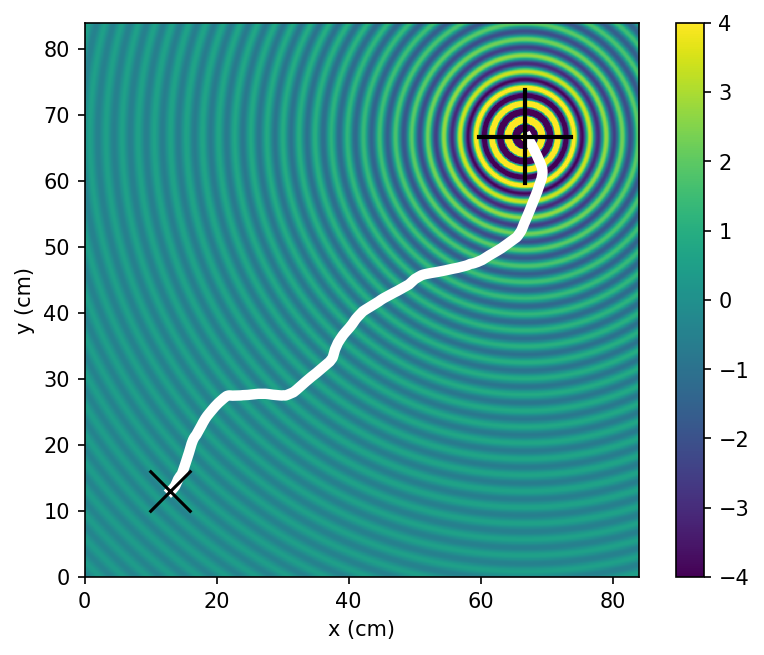

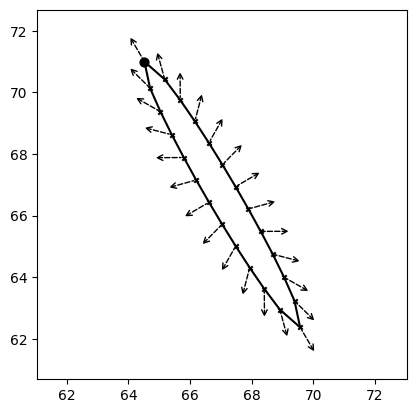

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

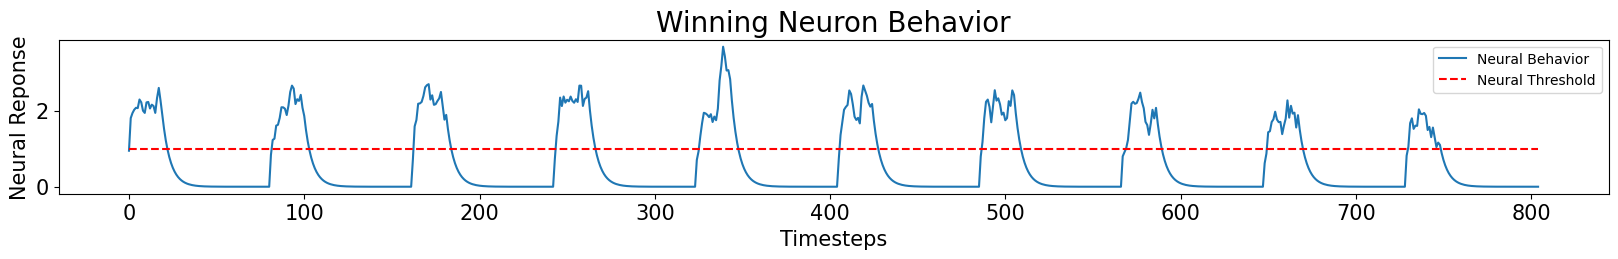

In [ ]:
### MAIN SCRIPT TO RUN SIMULATION AND PLOT SAMPLE TRAJECTORIES

# SET FRAMES PER SECOND, TIME CONSTANT VALUE, AND SIMULATION TIME

fps = 10 # Frames per second
tau = 1000 / fps # time constant
t = 180 # Simulation time in seconds
numFrames = int(np.round(t/(tau/1000))) # total number of timesteps performed

# ENVIRONMENT INSTANCE

bounds = 42 # set environment to be a 84x84cm square
targetLocation = 45 # sets the target location to be certain degrees from the horizontal on a 42cm radius circle in the environment
e = Environment(bounds,bounds,bounds,targetLocation)

# NEURAL FIELD INSTANCE

# orientation_init = 90 # initial orientation for the agent
orientation_init = random.randint(-180,180) # random initial orientation for the agent
print(f'Initial orientation: {approxBearingString(orientation_init)} ({orientation_init} degrees)')
nf = WilsonNF([0,0],[orientation_init,orientation_init],tau)
nf.setNumOfNodes(24)
nf.setDecay(0.06)
nf.setThreshold(0.001)

# AGENT INSTANCE

[x_init, y_init] = [13,13] # starting coordinate for the agent
a = AgentNF("Medium",x_init,y_init,orientation_init,nf,ignore_boundaries=False)

 # SET FREQUENCY AND DEPTH (updated later in script using set functions)

frequency = 1
depth = 1

# SET SIMULATION COMPONENTS AND PARAMETERS FOR SIMULATION INSTANCE

sensor_distortions = {
  # negative = agent's right, positive = agent's left
#   -180: {'multiplierConstant': 0},
#   -165: {'multiplierConstant': 0},
#   -150: {'multiplierConstant': 0},
#   -135: {'multiplierConstant': 0},
#   -120: {'multiplierConstant': 0},
#   -105: {'multiplierConstant': 0},
#    -90: {'multiplierConstant': 0},
#    -75: {'multiplierConstant': 0},
#    -60: {'multiplierConstant': 0},
#    -45: {'multiplierConstant': 0},
#    -30: {'multiplierConstant': 0},
#    -15: {'multiplierConstant': 0},
#      0: {'multiplierConstant': 0},
#     15: {'multiplierConstant': 0},
#     30: {'multiplierConstant': 0},
#     45: {'multiplierConstant': 0},
#     60: {'multiplierConstant': 0},
#     75: {'multiplierConstant': 0},
#     90: {'multiplierConstant': 0},
#     105: {'multiplierConstant': 0},
#     120: {'multiplierConstant': 0},
#     135: {'multiplierConstant': 0},
#     150: {'multiplierConstant': 0},
#     165: {'multiplierConstant': 0},
}

# sensor_distortion_label = 'No sensors distorted';  sensor_distortions = {}
# sensor_distortion_label = 'Odd sensors ablated';   sensor_distortions = {ang:{'multiplierConstant': 0} for ang in [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]}
# sensor_distortion_label = 'Even sensors ablated';  sensor_distortions = {ang:{'multiplierConstant': 0} for ang in [-165, -135, -105, -75, -45, -15, 15, 45, 75, 105, 135, 165]}
# sensor_distortion_label = 'Front sensors ablated'; sensor_distortions = {ang:{'multiplierConstant': 0} for ang in [-45, -30, -15, 0, 15, 30, 45]}
# sensor_distortion_label = 'Rear sensors ablated';  sensor_distortions = {ang:{'multiplierConstant': 0} for ang in [-180, -165, -150, -135, 135, 150, 165]}
# sensor_distortion_label = 'Right sensors ablated'; sensor_distortions = {ang:{'multiplierConstant': 0} for ang in [-135, -120, -105, -90, -75, -60, -45]}
# sensor_distortion_label = 'Left sensors ablated';  sensor_distortions = {ang:{'multiplierConstant': 0} for ang in [45, 60, 75, 90, 105, 120, 135]}

components = [e,nf,a]
parameters = [frequency,depth,numFrames,tau,sensor_distortions]

sim = Simulation(components,parameters)
sim.resetVals()
sim.setFrequency(4)
sim.setDepth(.1)
sim.setPixels(1000) # increasing pixels helps reduce aliased Moiré fringes at
                    # high frequencies, but figsize may need increased too

# RUN SIMULATION
sim.run()
if sim.success == 1:
  print("Successfully found the target")
else:
  print("Failed to find the target")

# TRAJECTORY PLOT

plt.figure(0, figsize=None, dpi=150)
sim.plotTrajectory(trajectory_color=('b' if sim.success else 'w'), trajectory_alpha=1, trajectory_lw=5, show_colorbar=True)
# fig0_title = plt.title('Trajectory Plot', fontsize = 15)

# AGENT AND SENSOR POSITION PLOT
plt.figure(1)
sim.agent.plotAgent('black')
sim.agent.plotSensors(sensor_distortions=sim.sensor_distortions)
xlim, ylim = sim.agent.height*1.2, sim.agent.height*1.2
plt.xlim([-xlim+sim.agent.x,xlim+sim.agent.x])
plt.ylim([-ylim+sim.agent.y,ylim+sim.agent.y])
plt.gca().set_aspect('equal')

# NEURAL FIELD INPUT PLOT

plt.figure(2)
input = nf.plotInputs(True)

# NEURAL FIELD OUTPUT PLOT

plt.figure(3)
outout = nf.plotOutputs(False, False)

# NEURAL FIELD MAXIMUM RESPONSE PLOT
fig3 = plt.figure(4, figsize=(20, 2))
nf.plotMaxResp()

#8. Data Collection

## 8.1 Data Collection Script to generate data in "Simulating Leech Navigation Using Neural Fields 2021"

The simulation script from section 7.5 can be expanded into a data collection script. Simply get rid of the plotting functions at the end and add a series of for loops to iterate over a range of different parameters, including wave frequency, water depth, agent size, sensor quantity, neural field synaptic weight scaling (number of connections), and sensory noise strength.

For my research I collected find rate data as a measurement for navigational performance. A find rate is the ratio of successful finds over a total number of trials for a given combination of parameters. Other performance metrics can be used such as path sinuosity which is the actual path length over the straight line distance.

This example stores data in panda dataframes which are then saved to a csv file in your google drive. This csv file can be accessed by mounting your google drive to google colab. Code is provided to do this but also use this reference [this google colab tutorial](https://colab.research.google.com/notebooks/io.ipynb) for more details.

This script iterates over one agent size, two sensor quantities, and six wave frequencies with only one trial performed each. Few trials are ran in this example for timing purposes.

In [ ]:
### SAMPLE DATA COLLECTION SCRIPT

start_sim = time.time() # Measure how long it takes to run code

# EXPERIMENTAL INPUTS

experiment_collection_name = 'testData'
ignore_boundaries = False
numSensors = [24]   # Different numbers of sensors
sensorDistortionsList = [('No sensors distorted', {})]  # Different patterns of sensor distortions (ablations, noise, bias)
neuralThresholds = [0.001, 0.02, 0.15, 0.5, 1]  # Different levels of the neural threshold
sizes = ["Medium"]  # Agent sizes (Small, Medium, Large)
depth = [.02]  # Depth inputs (m)
f = [2, 4, 8, 12, 20, 24]  # Frequency inputs (Hz)
trials = 50  # Number of trials per parameter combination


# experiment_collection_name = 'threshold-sweep'
# ignore_boundaries = True
# numSensors = [24]  # Different numbers of sensors
# sensorDistortionsList = [('No sensors distorted', {})]  # Different patterns of sensor distortions (ablations, noise, bias)
# neuralThresholds = [0.001, 0.005, 0.02, 0.05, 0.15, 0.2, 0.5, 1]  # Different levels of the neural threshold
# sizes = ["Medium"]  # Agent sizes (Small, Medium, Large)
# depth = [.02]  # Depth inputs (m)
# f = np.arange(1, 24+1)  # Frequency inputs (Hz)
# trials = 50  # Number of trials per parameter combination


# experiment_collection_name = 'ablated-sensors'
# ignore_boundaries = True
# numSensors = [24]  # Different numbers of sensors
# sensorDistortionsList = [  # Different patterns of sensor distortions (ablations, noise, bias)
#     ('Odd sensors ablated',   {ang:{'multiplierConstant': 0} for ang in [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]}),
#     ('Even sensors ablated',  {ang:{'multiplierConstant': 0} for ang in [-165, -135, -105, -75, -45, -15, 15, 45, 75, 105, 135, 165]}),
#     ('Front sensors ablated', {ang:{'multiplierConstant': 0} for ang in [-45, -30, -15, 0, 15, 30, 45]}),
#     ('Rear sensors ablated',  {ang:{'multiplierConstant': 0} for ang in [-180, -165, -150, -135, 135, 150, 165]}),
#     ('Right sensors ablated', {ang:{'multiplierConstant': 0} for ang in [-135, -120, -105, -90, -75, -60, -45]}),
#     ('Left sensors ablated',  {ang:{'multiplierConstant': 0} for ang in [45, 60, 75, 90, 105, 120, 135]}),
#     ('Front and rear sensors ablated', {ang:{'multiplierConstant': 0} for ang in [-45, -30, -15, 0, 15, 30, 45, -180, -165, -150, -135, 135, 150, 165]}),
# ]
# neuralThresholds = [0.15]  # Different levels of the neural threshold
# sizes = ["Medium"]  # Agent sizes (Small, Medium, Large)
# depth = [.02]  # Depth inputs (m)
# f = np.arange(1, 24+1)  # Frequency inputs (Hz)
# trials = 50  # Number of trials per parameter combination


# experiment_collection_name = 'noisy-sensors'
# ignore_boundaries = True
# numSensors = [24]  # Different numbers of sensors
# sensorDistortionsList = [  # Different patterns of sensor distortions (ablations, noise, bias)
#     ('Odd sensors noisy (sd=1)',   {ang:{'additiveRandomNormal': {'mean': 0, 'sd': 1}} for ang in [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]}),
#     ('Even sensors noisy (sd=1)',  {ang:{'additiveRandomNormal': {'mean': 0, 'sd': 1}} for ang in [-165, -135, -105, -75, -45, -15, 15, 45, 75, 105, 135, 165]}),
#     ('Front sensors noisy (sd=1)', {ang:{'additiveRandomNormal': {'mean': 0, 'sd': 1}} for ang in [-45, -30, -15, 0, 15, 30, 45]}),
#     ('Rear sensors noisy (sd=1)',  {ang:{'additiveRandomNormal': {'mean': 0, 'sd': 1}} for ang in [-180, -165, -150, -135, 135, 150, 165]}),
#     ('Right sensors noisy (sd=1)', {ang:{'additiveRandomNormal': {'mean': 0, 'sd': 1}} for ang in [-135, -120, -105, -90, -75, -60, -45]}),
#     ('Left sensors noisy (sd=1)',  {ang:{'additiveRandomNormal': {'mean': 0, 'sd': 1}} for ang in [45, 60, 75, 90, 105, 120, 135]}),
#     ('Front and rear sensors noisy (sd=1)', {ang:{'additiveRandomNormal': {'mean': 0, 'sd': 1}} for ang in [-45, -30, -15, 0, 15, 30, 45, -180, -165, -150, -135, 135, 150, 165]}),
# ]
# neuralThresholds = [0.15]  # Different levels of the neural threshold
# sizes = ["Medium"]  # Agent sizes (Small, Medium, Large)
# depth = [.02]  # Depth inputs (m)
# f = np.arange(1, 24+1)  # Frequency inputs (Hz)
# trials = 50  # Number of trials per parameter combination


# experiment_collection_name = 'biased-sensors'
# ignore_boundaries = True
# numSensors = [24]  # Different numbers of sensors
# sensorDistortionsList = [  # Different patterns of sensor distortions (ablations, noise, bias)
#     ('Odd sensors negatively biased (-1)',   {ang:{'additiveConstant': -1} for ang in [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]}),
#     ('Even sensors negatively biased (-1)',  {ang:{'additiveConstant': -1} for ang in [-165, -135, -105, -75, -45, -15, 15, 45, 75, 105, 135, 165]}),
#     ('Front sensors negatively biased (-1)', {ang:{'additiveConstant': -1} for ang in [-45, -30, -15, 0, 15, 30, 45]}),
#     ('Rear sensors negatively biased (-1)',  {ang:{'additiveConstant': -1} for ang in [-180, -165, -150, -135, 135, 150, 165]}),
#     ('Right sensors negatively biased (-1)', {ang:{'additiveConstant': -1} for ang in [-135, -120, -105, -90, -75, -60, -45]}),
#     ('Left sensors negatively biased (-1)',  {ang:{'additiveConstant': -1} for ang in [45, 60, 75, 90, 105, 120, 135]}),
#     ('Front and rear sensors negatively biased (-1)', {ang:{'additiveConstant': -1} for ang in [-45, -30, -15, 0, 15, 30, 45, -180, -165, -150, -135, 135, 150, 165]}),
# ]
# neuralThresholds = [0.15]  # Different levels of the neural threshold
# sizes = ["Medium"]  # Agent sizes (Small, Medium, Large)
# depth = [.02]  # Depth inputs (m)
# f = np.arange(1, 24+1)  # Frequency inputs (Hz)
# trials = 50  # Number of trials per parameter combination


# CREATE RESULTS DIRECTORY

timestamp = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
experiment_dir = working_dir / f'{experiment_collection_name} {timestamp}'
experiment_dir.mkdir(parents=True, exist_ok=True)

# SET FRAMES PER SECOND, TIME CONSTANT VALUE, AND SIMULATION TIME

fps = 10 # Frames per second
tau = 1000 / fps # time constant
t = 180 # Simulation time in seconds
numFrames = int(np.round(t/(tau/1000))) # total number of timesteps performed

# ENVIRONMENT INSTANCE

bounds = 42 # set environment to be a 84x84cm square
targetLocation = 45 # sets the target location to be certain degrees from the horizontal on a 42cm radius circle in the environment
simE = Environment(bounds,bounds,bounds,targetLocation)

# NEURAL FIELD INSTANCE

# orientation_init = 90 # initial orientation for the agent
orientation_init = random.randint(-180,180) # random initial orientation for the agent
simNF = WilsonNF([0,0],[orientation_init,orientation_init],tau)
simNF.setDecay(0.06)

# AGENT INSTANCE

[x_init, y_init] = [13,13] # starting coordinate for the agent
simAgent = AgentNF("Medium",x_init,y_init,orientation_init,simNF,ignore_boundaries=ignore_boundaries)

# SET SIMULATION COMPONENTS AND PARAMETERS FOR SIMULATION INSTANCE

frequency, depth = 1, 1 # Variables will be reset using setter functions
components = [simE,simNF,simAgent]
parameters = [frequency,depth,numFrames,tau,{}]
simData = Simulation(components,parameters)

### INITIALIZE DATA STORAGE MATRICES

N = len(f)
success = np.zeros((N,trials)) # Store find rate data

results_list = []

### Iterate over sensor count
for sensorIndx in trange(len(numSensors), desc='Sensors'):
    simNF.setNumOfNodes(numSensors[sensorIndx]) # Setting neural node quantity also sets sensor quantity

    ### Iterate over sensor distortions
    for sensorDistortionIndx in trange(len(sensorDistortionsList), desc='Sensor distortions'):
        sensor_distortion_label, sensor_distortions = sensorDistortionsList[sensorDistortionIndx]

        ### Iterate over neural threshold
        for neuralThresholdIndx in trange(len(neuralThresholds), desc='Neural thresholds', leave=False):
            simNF.setThreshold(neuralThresholds[neuralThresholdIndx])

            ### Iterate over agent size
            for sizeIndx in trange(len(sizes), desc='Sizes', leave=False):
                # New instance of agent with specific size and sensor quantity
                simA = AgentNF(sizes[sizeIndx],x_init,y_init,orientation_init,simNF,ignore_boundaries=ignore_boundaries)
                components = [simE,simNF,simA]
                parameters = [1,1,numFrames,tau,sensor_distortions]
                # New simData instance with updated agent
                simData = Simulation(components,parameters)

                ### Iterate over water depth
                for k in trange(len(depth), desc='Depths', leave=False):
                    simData.setDepth(depth[k])
                    legend_tuple = []
                    wavelength = np.zeros(N)

                    ### Iterate over wave frequency
                    for i in trange(len(f), desc='Frequencies', leave=False):
                        simData.setFrequency(f[i])
                        wavelength[i] = simData.waterWave.wavelength # Record wavelength
                        simData.setPixels(np.clip(10*round((2*bounds)/wavelength[i]), 200, 5000))  # increasing pixels helps reduce aliased Moiré fringes at
                                                                                                    # high frequencies, but figsize may need increased too

                        ### TRAJECTORY PLOTS: Start a new plot showing all trial trajectories
                        plt.figure(figsize=(10,10))
                        fig_filename = (experiment_dir /
                                        f'Trajectories__'
                                        f'Sensors-{numSensors[sensorIndx]}__'
                                        f'Distortions-{sensor_distortion_label.lower().replace(" ", "_")}__'
                                        f'Threshold-{simData.nf.threshold}__'
                                        f'Size-{sizes[sizeIndx].lower()}__'
                                        f'Depth-{depth[k]*100:g}-cm__'
                                        f'Freq-{f[i]}-Hz.png')

                        ### Iterate over number of trials per combination
                        for j in trange(trials, desc='Trials', leave=False):
                            # orientation_init = 90 # initial orientation for the agent
                            orientation_init = random.randint(-180,180) # random initial orientation for the agent
                            simData.agent_init[3] = orientation_init
                            simData.resetVals()
                            simData.run()

                            ### TRAJECTORY PLOTS: Add this trial to the plot
                            if j == 0:
                                plotFunc = simData.plotTrajectory
                            else:
                                plotFunc = simData.addTrajectory
                            if simData.success:
                                if trials > 1:
                                    trajectory_color = [(trials-1-j)/(trials-1), 0, 1]  # success: magenta to blue
                                else:
                                    trajectory_color = 'b'
                            else:
                                if trials > 1:
                                    trajectory_color = [j/(trials-1), j/(trials-1), j/(trials-1)]  # failure: black to white
                                else:
                                    trajectory_color = 'w'
                            plotFunc(trajectory_color=trajectory_color, trajectory_alpha=0.5)

                            success[i,j] = 1 if simData.success == 1 else 0

                        # Calculate find rate error (binomial standard deviation)
                        error = np.sqrt(trials * success[i].mean() * (1-success[i].mean())) / trials

                        # Add result for this iteration
                        results_list.append({
                            'Sensors': numSensors[sensorIndx],
                            'Sensor distortion label': sensor_distortion_label,
                            'Sensor distortions': simData.sensor_distortions,
                            'Ignore boundaries': simData.agent.ignore_boundaries,
                            'Size': sizes[sizeIndx],
                            'Depth (cm)': f'{depth[k]*100:g}',  # string makes this categorical when plotting with seaborn
                            'Frequency (Hz)': f[i],
                            'Wavelength (cm)': float(simData.waterWave.wavelength),
                            'Wavenumber (rad/cm)': float(simData.waterWave.k),
                            'Neural threshold': simData.nf.threshold,
                            'Neural decay (1/s)': simData.nf.decay/(simData.tau/1000),
                            'Environment radius (cm)': simData.env.r,
                            'Goal angle (deg)': np.degrees(simData.env.aG),
                            'Goal position (cm)': [simData.env.xG, simData.env.yG],
                            'Initial agent position (cm)': [x_init, y_init],
                            'Initial distance to goal (cm)': simData.agent.dist(x_init, y_init, simData.env.xG, simData.env.yG),
                            'Total time (s)': t,
                            'Tau (ms):': simData.tau,
                            'Number of frames': simData.numFrames,
                            'Trials': trials,
                            'Successes': int(success[i].sum()),
                            'Find Rate': success[i].mean(),
                            'Find Rate Error': error,
                            'Trajectory Plot': [str(Path(fig_filename.parent.name) / fig_filename.name)],
                            })

                        ### TRAJECTORY PLOTS: Add a descriptive title to the plot
                        plt.title(f'Sensors: {numSensors[sensorIndx]}, Distortions: {sensor_distortion_label}\n'
                                  f'Threshold: {simData.nf.threshold}, Size: {sizes[sizeIndx]}, Depth: {depth[k]*100:g} cm\n'
                                  f'Frequency: {f[i]} Hz, Wavelength: {round(simData.waterWave.wavelength*100)/100} cm\n'
                                  f'Trials: {trials}, Find rate: {round(success[i].mean()*1000)/10}%')

                        ### TRAJECTORY PLOTS: Export to file
                        ax = plt.gca()
                        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(20)
                        plt.tight_layout()
                        plt.gcf().savefig(str(fig_filename))
                        plt.close()

df = pd.DataFrame(results_list)

### PRINT DATAFRAME
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

### Save data to google drive
export_file = experiment_dir / 'results.csv'
df.to_csv(export_file, index=False)

print("It took",time.time()-start_sim,"seconds to run the simulation")

## 8.2 Data visualization

You can plot the data either immediately from the dataframe that we created from the previous script or by importing the data back into the notebook from your google drive.

In [ ]:
### VIEW SAVED TRAJECTORY PLOTS

def browse_images(df):
    out = widgets.Output()

    def showImagesHorizontally(ind):
        with out:
            out.clear_output(wait=False)
            print('\nLoading trajectory plot...')
            out.clear_output(wait=True)

            filename_list = df.loc[ind]['Trajectory Plot']
            if filename_list == []: print('\nNothing to display')
            images = []
            for filename in filename_list:
                byte_string = open(working_dir / filename, 'rb').read()
                image = widgets.Image(value=byte_string, format='png', width=450)
                images.append(image)
            display(widgets.HBox(images))

    selector_tuples = []
    for ind in df.index:
        row = df.loc[ind]
        name = ' | '.join([
                f'Index: {ind}',
                f'Sensors: {row["Sensors"]}',
                f'Distortions: {row["Sensor distortion label"]}',
                f'Threshold: {row["Neural threshold"]}',
                f'Size: {row["Size"][0] if type(row["Size"]) == str else row["Size"]}',
                f'Depth: {row["Depth (cm)"]} cm',
                f'Frequency: {row["Frequency (Hz)"]} Hz',
                # f'Wavelength: {row["Wavelength (cm)"]:.1f} cm',
                f'Trials: {row["Trials"]}',
                f'Find rate: {row["Find Rate"]*100:.1f}%'
                ])
        selector_tuples.append((name, ind))
    selector = widgets.Dropdown(options=selector_tuples, description='Experiment:', layout={'width': 'max-content'})
    widgets.interact(showImagesHorizontally, ind=selector)

    display(out)

### 8.2.1 Plot Data Directly From Dataframe

In [ ]:
### SHOW TRAJECTORY PLOTS
browse_images(df)

In [ ]:
### PLOT FIND RATE AS A FUNCTION OF FREQUENCY
sns.relplot(
    data=df,
    x='Frequency (Hz)',
    y='Find Rate',
    hue='Depth (cm)',
    style='Depth (cm)',
    dashes=False,
    markers=True,
    palette='tab10',  # tab10 is matplotlib's default qualitative colormap
    row='Neural threshold',
    # col='Size',
    kind='line',
    markersize=6,
    aspect=2,
    height=2.5,
)
plt.ylim(0, 1)
plt.suptitle('Find Rate vs. Wave Frequency')
plt.tight_layout(rect=(0, 0, 0.85, 0.98))

In [ ]:
# ### PLOT FIND RATE AS A FUNCTION OF WAVELENGTH
# sns.relplot(
#     data=df,
#     x='Wavelength (cm)',
#     y='Find Rate',
#     hue='Depth (cm)',
#     style='Depth (cm)',
#     dashes=False,
#     markers=True,
#     row='Neural threshold',
#     # col='Size',
#     kind='line',
#     markersize=6,
#     aspect=2,
#     height=2.5,
# )
# plt.ylim(0, 1)
# plt.suptitle('Find Rate vs. Wavelength')
# plt.tight_layout(rect=(0, 0, 0.85, 1))

### 8.2.2 Plot Data by Importing Dataframe From Drive

The code is commented out for now since you will need to manually retrieve the stored data from your own google drive.

In [ ]:
def import_and_merge_data(experiment_collection_name, working_dir=working_dir):
    working_dir = Path(working_dir)
    data_files = sorted(glob(str(working_dir / f'{experiment_collection_name} *' / 'results.csv')))

    if data_files == []:
        raise ValueError(f'No data folders were found in "{working_dir}" beginning with the experiment collection name "{experiment_collection_name}"')

    df = pd.read_csv(data_files[0])

    for next_file in data_files[1:]:
        next_df = pd.read_csv(next_file)

        # the list of column entries that must be identical in order for two
        # rows in different spreadsheets to be considered replicates of the
        # same simulation (NOT included in this list are Trials, Successes,
        # Find Rate, Find Rate Error, and Trajectory Plot)
        columns = [
            'Sensors',
            'Sensor distortion label',
            'Sensor distortions',
            'Ignore boundaries',
            'Size',
            'Depth (cm)',
            'Frequency (Hz)',
            'Wavelength (cm)',
            'Wavenumber (rad/cm)',
            'Neural threshold',
            'Neural decay (1/s)',
            'Environment radius (cm)',
            'Goal angle (deg)',
            'Goal position (cm)',
            'Initial agent position (cm)',
            'Initial distance to goal (cm)',
            'Total time (s)',
            'Tau (ms):',
            'Number of frames',
            ]
        df = df.merge(next_df, how='outer', on=columns)

        # merge trial counts for rows with matching simulation parameters
        df['Trials_x'] = df['Trials_x'].fillna(0).astype('int')
        df['Trials_y'] = df['Trials_y'].fillna(0).astype('int')
        df['Trials'] = df['Trials_x'] + df['Trials_y']

        # merge success counts for rows with matching simulation parameters
        df['Successes_x'] = df['Successes_x'].fillna(0).astype('int')
        df['Successes_y'] = df['Successes_y'].fillna(0).astype('int')
        df['Successes'] = df['Successes_x'] + df['Successes_y']

        # calculate the new total find rate across combined trials
        df['Find Rate'] = df['Successes'] / df['Trials']

        # calculate the new find rate error across combined trials (binomial standard deviation)
        df['Find Rate Error'] = np.sqrt(df['Trials'] * df['Find Rate'] * (1-df['Find Rate'])) / df['Trials']

        # merge lists of trajectory plot figures
        df['Trajectory Plot_x'] = df['Trajectory Plot_x'].fillna('[]').apply(lambda x: eval(x) if type(x) == str else x)
        df['Trajectory Plot_y'] = df['Trajectory Plot_y'].fillna('[]').apply(lambda y: eval(y) if type(y) == str else y)
        df['Trajectory Plot'] = df['Trajectory Plot_x'] + df['Trajectory Plot_y']

        # remove leftover columns from the merging process
        df = df.drop(columns=['Trials_x', 'Successes_x', 'Find Rate_x', 'Find Rate Error_x', 'Trajectory Plot_x', 'Trials_y', 'Successes_y', 'Find Rate_y', 'Find Rate Error_y', 'Trajectory Plot_y'])

    # df['Depth (cm)'] = df['Depth (cm)'].astype(str)  # string makes this categorical when plotting with seaborn

    # convert string representations into dictionaries
    df['Sensor distortions'] = df['Sensor distortions'].apply(eval)

    # convert string respresentations into lists
    df['Trajectory Plot'] = df['Trajectory Plot'].fillna('[]').apply(lambda z: eval(z) if type(z) == str else z)

    return df

def append_in_vivo_data(df):
    '''
    In vivo data from Harley et al. 2011 for adult leeches with mechanical
    stimulation only. Trial counts (sample sizes) were taken from Table 1.
    Successes were deduced from Figure 2A.
    '''
    data_in_vivo = pd.DataFrame.from_dict({
        'Frequency (Hz)': [2, 4, 8, 12, 20, 24],
        'Trials': [16, 15, 18, 18, 16, 17],
        'Successes': [3, 4, 8, 9, 5, 5],
    })
    data_in_vivo['Find Rate'] = data_in_vivo['Successes'] / data_in_vivo['Trials']
    data_in_vivo['Find Rate Error'] = np.sqrt(data_in_vivo['Trials'] * data_in_vivo['Find Rate'] * (1-data_in_vivo['Find Rate'])) / data_in_vivo['Trials']
    data_in_vivo['Depth (cm)'] = 2
    data_in_vivo['Sensor distortion label'] = 'In vivo data'
    data_in_vivo['Neural threshold'] = 'In vivo data'
    data_in_vivo['Sensor distortions'] = [{}] * len(data_in_vivo)
    data_in_vivo['Trajectory Plot'] = [[]] * len(data_in_vivo)
    return pd.concat([df, data_in_vivo], ignore_index=True)

def column_sorter(column):
    match column.name:
        case 'Depth (cm)' | 'Frequency (Hz)':
            # purely numeric columns just work as is
            return column
        case 'Neural threshold':
            def threshold_sorter(threshold):
                if threshold == 'In vivo data': return 0
                else: return threshold
            return column.map(threshold_sorter)
        case 'Sensor distortion label':
            def label_sorter(label):
                regex_order = ['In vivo data', 'No sensors distorted', 'Odd .*', 'Even .*', 'Front and rear .*', 'Front .*', 'Rear .*', 'Right .*', 'Left .*']
                for i, pattern in enumerate(regex_order):
                    if re.fullmatch(pattern, label): return i
                raise ValueError(f'unsure how to sort sensor distortion label "{label}"')
            return column.map(label_sorter)
        case _:
            raise ValueError(f'unsure how to sort column "{column.name}"')

data = import_and_merge_data('testData')

data = append_in_vivo_data(data)

data = data.sort_values(by=[
    'Neural threshold',
    'Depth (cm)',
    'Sensor distortion label',
    'Frequency (Hz)',
], key=column_sorter, na_position='first', ignore_index=True)

In [ ]:
### EXPORT SUMMARY TABLE

depth = 2  # cm
thresholds = ['In vivo data', 0.001, 0.005, 0.02, 0.05, 0.15, 0.2, 0.5, 1.0]

data2 = data.copy()
data2 = data2[data2['Depth (cm)'] == depth]
data2 = data2[data2['Neural threshold'].map(lambda threshold: threshold in thresholds)]
data2 = data2.drop([
    'Sensors',
    'Sensor distortions',
    'Ignore boundaries',
    'Size',
    'Depth (cm)',
    'Wavelength (cm)',
    'Wavenumber (rad/cm)',
    'Neural decay (1/s)',
    'Environment radius (cm)',
    'Goal angle (deg)',
    'Goal position (cm)',
    'Initial agent position (cm)',
    'Initial distance to goal (cm)',
    'Total time (s)',
    'Tau (ms):',
    'Number of frames',
    'Trajectory Plot',
    ], axis=1)
data2 = data2.reset_index(drop=True)
data2.to_csv('leech-simulation-data.csv', float_format='%.3g', index=False)

In [ ]:
### SHOW TRAJECTORY PLOTS
browse_images(data)

In [ ]:
### PLOT FIND RATE AS A FUNCTION OF FREQUENCY
sns.relplot(
    data=data, #[data['Neural threshold']==5],
    x='Frequency (Hz)',
    y='Find Rate',
    hue='Depth (cm)',
    style='Depth (cm)',
    dashes=False,
    markers=True,
    palette='tab10',  # tab10 is matplotlib's default qualitative colormap
    row='Neural threshold',
    # col='Size',
    kind='line',
    markersize=6,
    aspect=2,
    height=2.5,
)
plt.ylim(0, 1)
plt.suptitle('Find Rate vs. Wave Frequency')
plt.tight_layout(rect=(0, 0, 0.85, 0.98))

In [ ]:
# ### PLOT FIND RATE AS A FUNCTION OF FREQUENCY

# depth = 10

# with sns.plotting_context('paper', font_scale=1.5):
#     sns.relplot(
#         data=data[data['Depth (cm)'] == depth],
#         x='Frequency (Hz)',
#         y='Find Rate',
#         hue='Neural threshold',
#         style='Neural threshold',
#         dashes=False,
#         markers=True,
#         # palette='tab10',  # tab10 is matplotlib's default qualitative colormap
#         row='Depth (cm)',
#         # col='Size',
#         kind='line',
#         marker='o',
#         markersize=6,
#         aspect=3,
#         height=4,
#         legend='full',
#     )
#     plt.ylim(0, 1)
#     plt.title(f'Depth: {depth} cm')
#     plt.tight_layout(rect=(0, 0, 0.9, 1))

In [ ]:
### PLOT FIND RATE AS A FUNCTION OF FREQUENCY

thresholds = ['In vivo data', 0.001, 0.005, 0.02, 0.05, 0.15, 0.2, 0.5, 1.0]
depth = 2
sensor_distortion_label_regex = re.compile('No sensors distorted|In vivo data')

linewidths = dict(map(lambda threshold: (threshold, 1), thresholds))
linewidths[0.15] = 3
linewidths['In vivo data'] = 3

data2 = data.copy()
data2 = data2[data2['Neural threshold'].map(lambda threshold: threshold in thresholds)]
data2 = data2[(data2['Depth (cm)'] == depth) + (data2['Neural threshold'] == 'In vivo data')]
data2 = data2[data2['Sensor distortion label'].apply(lambda label: sensor_distortion_label_regex.fullmatch(label) is not None)]

my_palette = {'In vivo data': 'C0'}
for i, threshold in enumerate(thresholds):
    if type(threshold) is not str and np.isfinite(threshold):
        my_palette[threshold] = [(len(thresholds)-i)/len(thresholds)]*3

with sns.plotting_context('paper', font_scale=1.5):
    fig = plt.figure(figsize=(11, 4))
    ax = sns.lineplot(
        data=data2,
        x='Frequency (Hz)',
        y='Find Rate',
        size='Neural threshold',
        sizes=linewidths,
        hue='Neural threshold',
        style='Neural threshold',
        dashes=False,
        markers=True,
        palette=my_palette,
        markersize=10,
    )
    ax.legend(title='Neural threshold', loc='center left', bbox_to_anchor=(1, 0.5), edgecolor='none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # add error bars representing binomial standard deviation
    for i, threshold in enumerate(thresholds):
        ax.errorbar(
            x=data2[data2['Neural threshold'] == threshold]['Frequency (Hz)'],
            y=data2[data2['Neural threshold'] == threshold]['Find Rate'],
            yerr=data2[data2['Neural threshold'] == threshold]['Find Rate Error'],
            color=my_palette[threshold]
            fmt='none',
            capsize=5,
            zorder=1,
        )

    # add gray rectangle to 8-12 Hz range
    import matplotlib.patches as patches
    rect = patches.Rectangle((8, 0), 4, 1, linewidth=0, edgecolor='none', facecolor='#eeeeee', zorder=-1)
    ax.add_patch(rect)

    plt.xticks(np.arange(0, data2['Frequency (Hz)'].max()+1, 4))
    plt.ylim(0, 1)
    plt.title(f'Depth: {depth} cm')
    plt.tight_layout()

In [ ]:
### PLOT FIND RATE AS A FUNCTION OF FREQUENCY

threshold = 0.15

data2 = data.copy()
data2 = data2[data2['Neural threshold'] == threshold]

with sns.plotting_context('paper', font_scale=1.5):
    fig = plt.figure(figsize=(10.46, 4))
    ax = sns.lineplot(
        data=data2,
        x='Frequency (Hz)',
        y='Find Rate',
        hue='Depth (cm)',
        style='Depth (cm)',
        dashes=False,
        markers=True,
        palette='tab10',  # tab10 is matplotlib's default qualitative colormap
        markersize=10,
    )
    ax.legend(title='Depth (cm)', loc='center left', bbox_to_anchor=(1, 0.5), edgecolor='none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # add error bars representing binomial standard deviation
    for i, depth in enumerate(data2['Depth (cm)'].unique()):
        ax.errorbar(
            x=data2[data2['Depth (cm)'] == depth]['Frequency (Hz)'],
            y=data2[data2['Depth (cm)'] == depth]['Find Rate'],
            yerr=data2[data2['Depth (cm)'] == depth]['Find Rate Error'],
            color=f'C{i}',
            fmt='none',
            capsize=5,
            zorder=1,
        )

    plt.xticks(np.arange(0, data2['Frequency (Hz)'].max()+1, 4))
    plt.ylim(0, 1)
    plt.title(f'Neural threshold: {threshold}')
    plt.tight_layout()

In [ ]:
# ### PLOT FIND RATE AS A FUNCTION OF WAVELENGTH
# sns.relplot(
#     data=data,
#     x='Wavelength (cm)',
#     y='Find Rate',
#     hue='Depth (cm)',
#     style='Depth (cm)',
#     dashes=False,
#     markers=True,
#     row='Neural threshold',
#     # col='Size',
#     kind='line',
#     markersize=6,
#     aspect=2,
#     height=2.5,
# )
# plt.ylim(0, 1)
# plt.suptitle('Find Rate vs. Wavelength')
# plt.tight_layout(rect=(0, 0, 0.85, 1))

**Plot find rate vs freq/wavelength for multiple depths**

**Plot find rate vs freq/wavelength for different sensor distortions**

In [ ]:
### PLOT FIND RATE AS A FUNCTION OF FREQUENCY

threshold = 0.15
depth = 2  # cm
sensor_distortion_label_regex = re.compile('No sensors distorted|.* ablated')

data2 = data.copy()
data2 = data2[data2['Neural threshold'].map(lambda nt: nt in [threshold, 'In vivo data'])]
data2 = data2[data2['Depth (cm)'] == depth]
data2 = data2[data2['Sensor distortion label'].apply(lambda label: sensor_distortion_label_regex.fullmatch(label) is not None)]

linewidths = dict(map(lambda label: (label, 1), data2['Sensor distortion label'].unique()))
linewidths['No sensors distorted'] = 3

my_palette = {'No sensors distorted': 'gray'}
for i, label in enumerate(data2['Sensor distortion label'].unique()[1:]):
    my_palette[label] = sns.color_palette('Set2', len(data2['Sensor distortion label'].unique())-1)[i]

with sns.plotting_context('paper', font_scale=1.5):
    fig = plt.figure(figsize=(11, 4))
    ax = sns.lineplot(
        data=data2,
        x='Frequency (Hz)',
        y='Find Rate',
        size='Sensor distortion label',
        sizes=linewidths,
        hue='Sensor distortion label',
        style='Sensor distortion label',
        dashes=False,
        markers=True,
        palette=my_palette,
        markersize=10,
    )
    ax.legend(title='Sensor distortions', loc='center left', bbox_to_anchor=(1, 0.5), edgecolor='none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # add error bars representing binomial standard deviation
    for i, sensor_distortions in enumerate(data2['Sensor distortion label'].unique()):
        ax.errorbar(
            x=data2[data2['Sensor distortion label'] == sensor_distortions]['Frequency (Hz)'],
            y=data2[data2['Sensor distortion label'] == sensor_distortions]['Find Rate'],
            yerr=data2[data2['Sensor distortion label'] == sensor_distortions]['Find Rate Error'],
            color=my_palette[sensor_distortions],
            fmt='none',
            capsize=5,
            zorder=1,
        )

    # add gray rectangle to 8-12 Hz range
    import matplotlib.patches as patches
    rect = patches.Rectangle((8, 0), 4, 1, linewidth=0, edgecolor='none', facecolor='#eeeeee', zorder=-1)
    ax.add_patch(rect)

    plt.xticks(np.arange(0, data2['Frequency (Hz)'].max()+1, 4))
    plt.ylim(0, 1)
    # plt.title(f'Neural threshold: {threshold}\nDepth: {depth} cm')
    plt.tight_layout()

In [ ]:
### PLOT DISTORTED SENSORS DIAGRAM

from seaborn._base import unique_markers

refAgent = AgentNF('Medium', 0, 0, 90, WilsonNF([],[],10))
xlim, ylim = refAgent.width*3, refAgent.height*1.5

ncols = 1
figsize = (4, 4)

sensor_distortion_labels_unique = data2['Sensor distortion label'].unique()

nplots = len(sensor_distortion_labels_unique)
nrows = int(np.ceil(nplots/ncols))
markers = unique_markers(nplots)
for i in range(nrows):
    for j in range(ncols):
        fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=1)
        ax.set_axis_off()
        ax.set_xlim([-xlim+refAgent.x, xlim+refAgent.x])
        ax.set_ylim([-ylim+refAgent.y, ylim+refAgent.y])
        ax.set_aspect('equal')

        ind = i*ncols+j
        if ind < nplots:
            sensor_distortion_label = sensor_distortion_labels_unique[ind]
            sensor_distortions = data2[data2['Sensor distortion label'] == sensor_distortion_label]['Sensor distortions'].iloc[0]
            refAgent.plotAgentAx(ax=ax, color='black')
            refAgent.plotSensors(ax=ax, sensor_distortions=sensor_distortions)
            ax.set_title(sensor_distortion_label, y=0.95, fontdict={'fontsize': 10})
            ax.scatter([refAgent.x], [refAgent.y+refAgent.height*1.3], c=[my_palette[sensor_distortion_label]], marker=markers[ind])

In [ ]:
### SHOW TRAJECTORY PLOTS
browse_images(data2)

#9. Extra Figures and Animations

## 9.1 Positive and Negative Sensor Locations

This plot shows exactly which sensors are negative and which sensors are positive. It also displays each sensor's index which correlates with index of output from the **AgentNF.sensors()** function from section 4.2.

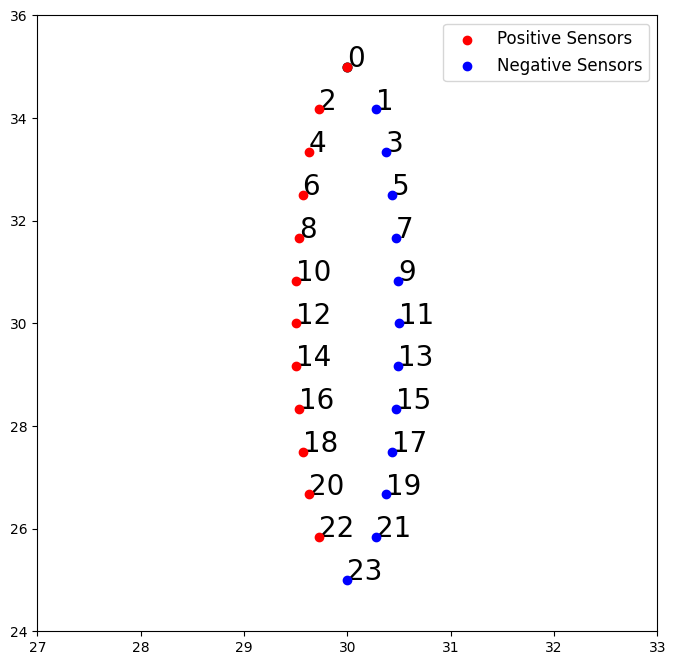

In [ ]:
tau = 10 # Time constant
testNF = WilsonNF([],[],tau)
referenceAgent = AgentNF('Medium',30,30,90,testNF)
plt.figure(figsize = (8,8))
referenceAgent.plotAgent('white')

for i, (relativeAngle, (x,y), (vx, vy, _)) in enumerate(referenceAgent.sensors()):
    ### Positive elliptical points
    if i%2 == 0 and i != (referenceAgent.coordsP.shape[1]*2)-2:
        legLabel = 'Positive Sensors' if i == 0 else '_nolegend_'
        plt.scatter(x, y, c='red', label=legLabel, zorder=20)
        plt.annotate(str(i), fontsize=20, xy=(x, y), zorder=10)

    ### Negative elliptical points
    elif i%2 != 0 or i == (referenceAgent.coordsP.shape[1]*2)-1:
        legLabel = 'Negative Sensors' if i == 1 else '_nolegend_'
        plt.scatter(x, y, c='blue', label=legLabel, zorder=20)
        plt.annotate(str(i),fontsize=20, xy=(x, y), zorder=10)

    else: continue

xlim, ylim = referenceAgent.width*6, referenceAgent.height*1.2
plt.xlim([-xlim+referenceAgent.x,xlim+referenceAgent.x])
plt.ylim([-ylim+referenceAgent.y,ylim+referenceAgent.y])
leg = plt.legend(fontsize = 12)


## 9.2 Sensor Detection Vectors

The following code plots an agent with all of its sensor positions and sensor detection vectors. It also plots all of the water vectors for a given stimulus and gives a visual representation of how *waterVector* is projected onto *sensorVector*. The code for doing this is describes in the **Simulation.updateSingleSensor(...)** function from section 7.2.
- *sensorVector*: black dashed arrows
- *waterVector*: blue lines
- Projected vectors: yellow-red bars

This script uses a lot of the same code from the simulation source code, but with added plotting features. Reference sections 7.1, 7.2, and 7.4 for more details on how this script works.

In [ ]:
### AGENT VECTOR PLOT

fig, ax = plt.subplots(figsize = (10,10))

# HELPER FUNCTIONS

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def sensorVector(v,theta):
  theta = theta*(pi/180)
  x = v*cos(theta)
  y = v*sin(theta)
  return x,y,0

def vectorProjection(a,b):
  # a is the wave vector
  # b is the detection vector
  num = np.dot(a,b)
  dem = b[0]**2 + b[1]**2
  return np.multiply((num/dem),b)

### MAIN PLOTTING FUNCTION (code similar to simulation update function)

def plotSensorBehavior(testAgent,stimOrigin,stimLinesBool,ax):
  ang = testAgent.actualAngle

  testEnvironment = Environment(50, 50, 50, 90)
  testEnvironment.setTargetLocation(*stimOrigin)
  frequency, depth = 5, 1
  testWave = Wave(testEnvironment, frequency, depth)
  testWave.update(1)
  waveBg = testWave.plotWave()
  waveBg.set_alpha(0.3)

  for i, (relativeAngle, (x,y), (vx, vy, vz)) in enumerate(testAgent.sensors()):

    ### Find sensor detector vectors
    sensorAngleP = relativeAngle + ang*(180/pi)
    sensorPVector = sensorVector(aTest.height/5,sensorAngleP)
    # sensorPVector = (vx/100*aTest.height/5, vy/100*aTest.height/5, vz/100*aTest.height/5)
    p1 = [x, x+sensorPVector[0]]
    p2 = [y, y+sensorPVector[1]]

    ### Plot sensor detection vectors
    ax.annotate(text='', xy=(x, y), xytext=(x+sensorPVector[0], y+sensorPVector[1]), arrowprops=dict(arrowstyle='<-',ls='--'))

    ### Water vector (rotated about agent's origin)  # JPG 2024-07-18 really not sure why this was here
    # xRot, yRot, theta = stimOrigin[0]-testAgent.x, stimOrigin[1]-testAgent.y, (pi/2)-ang
    # xPoint = ((xRot*cos(theta)-yRot*sin(theta))+testAgent.x)
    # yPoint = ((yRot*cos(theta) + xRot*sin(theta))+testAgent.y)
    # wX = xPoint - x
    # wY = yPoint - y

    xPoint = stimOrigin[0]
    yPoint = stimOrigin[1]
    wX = xPoint - x
    wY = yPoint - y

    waterPVector = [wX,wY,0] / (np.sqrt(wX**2 + wY**2))*3

    angleP = testAgent.findWaterAngle(sensorPVector,waterPVector)

    if abs(angleP) <= 90:
        ### Plot water vectors
        if stimLinesBool:
            arrow_props = dict(arrowstyle='<-', color='b', ls='-')
            ax.annotate(text='', xy=(xPoint, yPoint), xytext=(x, y), arrowprops=arrow_props)

        ### Project of water vector onto sensor detection vector
        pProj = testAgent.vectorProjection(waterPVector, sensorPVector)

        ### Scale by local wave amplitude
        pProj = testWave.amplitude_envelope(x, y) * pProj

        magnitude = np.sqrt(pProj[0]**2 + pProj[1]**2)
        magnitude = magnitude*1.45

        ### Plot projection vectors
        histScale = 4 # scaled so that projections are on the same scale as sensor vectors
        ax.plot(
            [x, x+pProj[0]*histScale], [y, y+pProj[1]*histScale],
            color=colorFader('yellow','red',magnitude),
            linewidth = 10,
            solid_capstyle='butt',
            zorder=1)

    ### Plot sensor coordinate points
    ax.scatter(testAgent.coordsN[0],testAgent.coordsN[1],color='k')
    ax.scatter(testAgent.coordsP[0],testAgent.coordsP[1],color='k')
    ax.plot(testAgent.coordsN[0],testAgent.coordsN[1],color='k',zorder=10)
    ax.plot(testAgent.coordsP[0],testAgent.coordsP[1],color='k',zorder=10)

### Neural field and agent instances
tau = 10 # Time constant
testNF = WilsonNF([],[],tau)
testNF.setNumOfNodes(24)
aTest = AgentNF('Large',45,65,0,testNF)

### Set stimulus origin and call plotting function
stimOrigin = [30, 80]
ang = pi/2; aTest.rotateAgent(ang); aTest.actualAngle += ang;  # JPG 2024-07-18 Agent.rotateAgent fails to update actualAngle so we must do it here
plotSensorBehavior(aTest,stimOrigin,True,ax)
ax.set_xlim([26, 50])
ax.set_ylim([46, 85])
ax.set_axis_off()

## 9.3 Leech Movement Animation

The scripts below outputs an animation of an agent moving around in a behavioral arena with the water wave propagating through space. It also shows how the sensors are updated in real time as the agent moves around.

### 9.3.1 Helper Functions

Details on these helper functions can be found from sections 7.2 and 7.4.

In [ ]:
def sensorVector(v,theta):

  theta = theta*(pi/180)
  x = v*cos(theta)
  y = v*sin(theta)
  return x,y,0

def plotAgentModel(AgentNF,ax):

  testAgent = AgentNF
  ax.plot(testAgent.coordsN[0],testAgent.coordsN[1],color='k')
  ax.plot(testAgent.coordsP[0],testAgent.coordsP[1],color='k')
  xlim, ylim = testAgent.height*1.5, testAgent.height*1.5
  ax.set_xlim([-xlim+testAgent.x,xlim+testAgent.x])
  ax.set_ylim([-ylim+testAgent.y,ylim+testAgent.y])

def updateSensors(agent,env,waterWave,sizes,angles,frame):
  # Check the intensity and direction of the water wave at each sensor position
  for i, (relativeAngle, (x,y), sensorVector) in enumerate(agent.sensors()):
    updateSingleSensor(i, relativeAngle, x, y, sensorVector, agent,env,waterWave,sizes,angles,frame)

def updateSingleSensor(i, relativeAngle, x, y, sensorVector, agent,env,waterWave,sizes,angles,frame):

  ### Water stimuli vector
  wX = env.xG - x # x component
  wY = env.yG - y # y component
  waterVector = ([wX,wY,0] / (np.sqrt(wX**2 + wY**2)))*(waterWave.k*.4)

  ### Find angle between two vectors
  angle = agent.findWaterAngle(sensorVector,waterVector)

  if abs(angle) < 90:
    ### Find the projection of the water vector onto the sensor detector vector
    proj = agent.vectorProjection(waterVector,sensorVector)
    magnitude = np.sqrt(proj[0]**2 + proj[1]**2)

    ### Save magnitudes and directions
    sizes[i,frame+1] = magnitude
    angles[i,frame+1] = relativeAngle

  else:
    ### Save magnitudes and directions
    sizes[i,frame+1] = 0
    angles[i,frame+1] = relativeAngle

def updateAgentMotion(agent,env,perceived):

  turnAngle = 0
  if len(perceived) == 0:
      # If no percieved directions were returned then the agent performs a random turn
      # and has a 50% chance of moving in that direction
      turnAngle = random.randint(-45,45)
      vel = agent.updateOrientationVector(turnAngle)
      if random.randint(0,4) > 1:
        pos = agent.updatePosition(env)
  else:
    #  Otherwise choose one of the perceived directions at random
    turnAngle = perceived[random.randint(0,len(perceived)-1)]
    if abs(turnAngle) > 5:
      # If the perceived angle is greater than 5 degrees then it turns, updates its orientation and move
      vel = agent.updateOrientationVector(turnAngle)
      pos = agent.updatePosition(env)
    else:
      # Else just move
      pos = agent.updatePosition(env)

  return turnAngle

### 9.3.2 Main Update Function

This function is almost the exact same as the update function in the simulation class. The animation controller needs a function input, therefore the function was rewritten for this purpose. It includes many additional plotting features. Please reference sections 7.2 and 7.4 for more details.

In [ ]:
### ANIMATION SCRIPT

start_time = time.time()

# SET FRAMES PER SECOND, TIME CONSTANT VALUE, AND SIMULATION TIME
fps = 10
t = 5 # time in seconds
tau = 1000 / fps # 16.67 for fps of 60, 33.3 for fps of 30, 100 for fps of 10
numFrames = int(np.round(t/(tau/1000)))

# ENVIRONMENT INSTANCE

bounds = 42
targetLocation = 90
eMovie = Environment(bounds,bounds,bounds,targetLocation)

# NEURAL FIELD INSTANCE

orientation_init = 0
nfMovie = WilsonNF([0,0],[orientation_init,orientation_init],tau)
nfMovie.setDecay(.06)
nfMovie.setNumOfNodes(24)
nfMovie.setThreshold(0.5)

# AGENT INSTANCE
[x_init, y_init] = [42,13] # starting coordinate for the agent
aMovie = AgentNF("Medium",x_init,y_init,orientation_init,nfMovie)

# WATER WAVE INSTANCE
frequency, depth = 6, 0.01
waterMovie = Wave(eMovie,frequency,depth)

# SET UP PLOTS FOR LEECH MOVEMENT (right) AND SENSOR BEHAVIOR (left)

fig,ax = plt.subplots(1,2,figsize=(14,6))
fig.subplots_adjust(wspace=.4)

# POSITION STORAGE ARRAY
positions = np.zeros((numFrames+2,2))
positions[0,:] = [aMovie.x,aMovie.y] # Add initial position

# SENSOR MAGNITUDE AND DIRECTION MATRICES

sizes = np.zeros(((aMovie.coordsP.shape[1]*2)-1,numFrames+2))
angles = np.zeros(((aMovie.coordsP.shape[1]*2)-1,numFrames+2))

### MAIN UPDATE FUNCTION

def update(frame_number):

    # Plot sensor detection graphs

    ax[1].cla() # Clear right plot
    plotSensorBehavior(aMovie,[eMovie.xG,eMovie.yG],False,ax[1])

    # Set up leech movement plot

    ax[0].cla() # Clear left plot
    ax[0].set_xlabel("x (cm)")
    ax[0].set_ylabel("y (cm)")
    ax[0].set_title("Agent Motion - wave frequency ={}Hz" \
                    .format(np.round(waterMovie.frequency,decimals = 1)))
    ax[0].set_xlim((0, eMovie.x*2))
    ax[0].set_ylim((0, eMovie.y*2))

    # Plot agent with preferred color

    agent = aMovie.plotAgentAx('brown',ax[0])

    # Update water wave and plot

    timet = (frame_number*(tau/1000))
    k = waterMovie.update(timet)
    waterMovie.plotWaveAx(ax[0])

    # Sensor variables

    cP, cN = 0, 1 # Positive and negative sensor pointers
    totalSensorCount = 0 # Total sensor count
    active_deactiveFlag = 2/(tau/1000)

    # Sensors remain actived for 2 seconds, then off for 6 seconds
    if frame_number%((active_deactiveFlag*4)+1) < active_deactiveFlag:

      ### Activated Sensors
      updateSensors(aMovie,eMovie,waterMovie,sizes,angles,frame_number)
      perceived = nfMovie.updateNF(sizes[:,frame_number+1],angles[:,frame_number+1],noiseBool = True)
      turnAngle = updateAgentMotion(aMovie, eMovie, perceived)

    else:
      ### Deactivated Sensors
      perceived = nfMovie.updateNF([],[],noiseBool = True) # Neural field receives zero input
      turnAngle = updateAgentMotion(aMovie, eMovie, perceived)

    # Real time data labels
    positions[1+frame_number,:] = aMovie.x,aMovie.y
    ax[0].text(85, 75, 'Perceived: {}'.format(np.round(turnAngle,decimals=1), fontsize=10))
    ax[0].text(85, 70, 'Orientation: {}'.format(np.round((aMovie.actualAngle%(2*pi)*(180/pi)),decimals=1), fontsize=10))
    ax[0].text(85, 65, 'Xcoordinate: {}'.format(np.round(aMovie.x,decimals=1)), fontsize=10)
    ax[0].text(85, 60, 'Ycoordinate: {}'.format(np.round(aMovie.y,decimals=1)), fontsize=10)
    ax[0].text(85, 55, 'Time: {}'.format(np.round(frame_number * (tau/1000),decimals = 2)), fontsize = 10)

# Creating the Animation object
speed_up = 1
line_ani = animation.FuncAnimation(
    fig, update, frames = numFrames, interval=tau/speed_up)

from IPython.display import HTML
# HTML(line_ani.to_jshtml())
# line_ani.save('Movies/LeechSimulate.mp4', writer="ffmpeg")
HTML(line_ani.to_html5_video())
